In [3]:
from pv_analyzer import pv_analyze
import numpy as np
import Tb_estimator as tb_est
from lteanalysis import LTEAnalysis
import corner
import matplotlib.pyplot as plt
import os
import pandas as pd

In [4]:
%matplotlib widget

## Rs with empkep

In [6]:
res_prefix = 'rs_empkep_fixr_results_all_err' # t1 -- > Normal results with corrections, t0 before corrections

### Some functions

In [7]:
def emp_kep_v(v_rot, v_100):        
        r_au = 100.*np.power(v_100/v_rot, 2)
        return r_au

def emp_kep_r(r, r_b, v_100):
        v_r = v_100*(r/r_b)**(-0.5)
        return v_r

In [8]:
def get_lte_grid(model, Ncol:list=[1.e17], Texe:list=[15.], tb7:float=10., tb6:float=8.,
                  figure=None, axes=None):
    """
    Parameters:
    -----------
    Ncol: list of column densities, by default assumes lower quantile, median and, upper quantile
    Texe: list of Excitation temperatures, by default assumes lower quantile, median and, upper quantile
    """

    Ncols = np.array([5.e16, Ncol[1], 1.e25]) # cm^-2  
    Texes = np.array([5, Texe[1],30., 60]) # K
    dv =    [7417.8, 7417.8] #    [7417.8, 7417.8] [0.5, 0.5]
    Xconv = 1.e-7

    fig, ax = model.makegrid(lines = 'c18o', J1 = 3, J2=2, Ncols = Ncols, Texes = Texes, 
                             delv = dv, Xconv = 1.e-7, fig = figure, ax = axes)

    Tb_7_pred = []
    Tb_6_pred = []


    for ni, nc in enumerate(Ncol):
        for ti, te in enumerate(Texe):
            Tb_7_pred.append(model.get_intensity(line = 'c18o', Ju = 3, Ncol = nc, Tex =te, delv = dv[0], Xconv=1.e-7))
            Tb_6_pred.append(model.get_intensity(line = 'c18o', Ju = 2, Ncol = nc, Tex = te, delv = dv[1], Xconv=1.e-7))

            
    # Get theoretical errors
    Tb7_med, Tb7_dIv_dN, Tb7_dIv_dT = model.get_intensity(line = 'c18o', Ju = 3, Ncol = Ncol[1], Tex =Texe[1], delv = dv[0], 
                                                           Xconv=1.e-7, return_errs = True)
    Tb6_med, Tb6_dIv_dN, Tb6_dIv_dT = model.get_intensity(line = 'c18o', Ju = 2, Ncol = Ncol[1], Tex =Texe[1], delv = dv[1], 
                                                           Xconv=1.e-7, return_errs = True)
    

    print(f"Tb7_dIv_dN = {Tb7_dIv_dN:.2e}, Tb6_dIv_dN = {Tb6_dIv_dN:.2e}")
    print(f"Tb7_dIv_dT = {Tb7_dIv_dT:.2f}, Tb6_dIv_dT = {Tb6_dIv_dT:.2f}")


    del_T_up = Texe[2] - Texe[1]
    del_T_dwn = Texe[1] - Texe[0]
    del_N_up = Ncol[2] - Ncol[1]
    del_N_dwn = Ncol[1] - Ncol[0]

    print(f"Ncols and lgNcols up {Ncol[2]:.2e}, lgNc = {np.log10(Ncol[2]):.2e}")
    print(f"Ncols and lgNcols med {Ncol[1]:.2e}, lgNc = {np.log10(Ncol[1]):.2e}")
    print(f"Ncols and lgNcols dwn {Ncol[0]:.2e}, lgNc = {np.log10(Ncol[0]):.2e}")

    print(f"del T -> + {del_T_up:.2f}, - {del_T_dwn:.2f}")
    print(f"del N -> + {del_N_up:.2e}, - {del_N_dwn:.2e}")

    Tb7_err_up = np.sqrt((del_N_up*Xconv*Tb7_dIv_dN)**2 + (del_T_up*Tb7_dIv_dT)**2)
    Tb7_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb7_dIv_dN)**2 + (del_T_dwn*Tb7_dIv_dT)**2)
    Tb7_thr_err = np.array([[Tb7_err_dwn, Tb7_err_up]])

    print(Tb7_thr_err)

    Tb6_err_up = np.sqrt((del_N_up*Xconv*Tb6_dIv_dN)**2 + (del_T_up*Tb6_dIv_dT)**2)
    Tb6_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb6_dIv_dN)**2 + (del_T_dwn*Tb6_dIv_dT)**2)
    Tb6_thr_err = np.array([[Tb6_err_dwn, Tb6_err_up]])

    print(Tb6_thr_err)

    Tb_7_err = np.array([[Tb_7_pred[4] - min(Tb_7_pred), max(Tb_7_pred) - Tb_7_pred[4]]])
    Tb_6_err = np.array([[Tb_6_pred[4]-min(Tb_6_pred), max(Tb_6_pred) - Tb_6_pred[4]]])
    
    ax.errorbar(Tb_7_pred[4], Tb_6_pred[4], xerr=Tb_7_err.T, yerr=Tb_6_err.T,
                color = 'green', marker = '^', label = 'Fit')
    
    ax.errorbar(Tb7_med, Tb6_med, xerr=Tb7_thr_err.T, yerr=Tb6_thr_err.T,
                color = 'k', marker = '^', capsize = 5.0, alpha = 0.5)
    

    ax.errorbar(tb7, tb6, xerr = np.sqrt((0.1*tb7)**2 + 1.08**2), 
                yerr = np.sqrt((0.1*tb6)**2 + 0.49**2),  
                color = 'red', marker = 'o', ms=5, label = 'Observed')
    
    ax.set_ylim(0,20)
    ax.set_xlim(0,20)

    plt.grid()

    
    plt.legend(prop={'size': 6})

    return fig, ax

### Temperature estimation (fix v)

#### Read the Data

In [6]:
# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    v_sys=7.27, is_Tb=True)
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_69_w1.fits',
                    v_sys=7.27, is_Tb=True)
pv_b6.read_pv(print_details = True)



Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
 rms = 1.08 K
Convert frequency to velocity
 rms = 6.92e-03 Jy beam$^-1$
 rms = 0.49 K


In [7]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = emp_kep_v, mode='func',
                                get_surrounding_pix = True, num_pix = 5,  get_pix_along='v',
                                cf_kwargs = {'v_100':2.674},)
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = emp_kep_v, mode='func',
                                get_surrounding_pix = True, num_pix = 5,  get_pix_along='v',
                                cf_kwargs = {'v_100':2.674})

In [ ]:
v_100 = 2.674
# Evaluate empirical keplerian curve function
r_rs_func = np.arange(start=1., step=0.5, stop=840.)   # Note that this is in AU
v_rs_func = emp_kep_r(r=r_rs_func, r_b=100., v_100=v_100)

r_bs_func = -r_rs_func
v_bs_func = -v_rs_func

#### Data Visualization

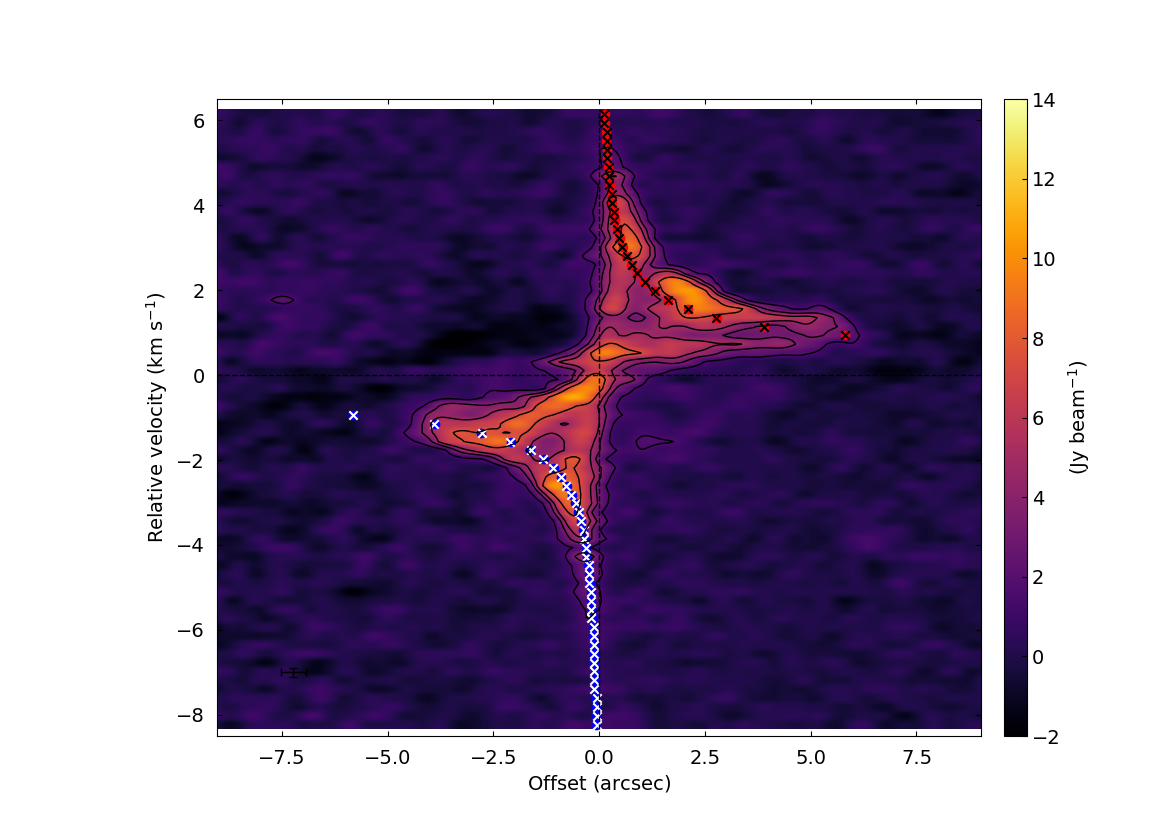

In [8]:
pv_dia6 = pv_b6.plot_pv(plot_curve=True)
pv_dia6[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_dia6[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)
pv_dia7 = pv_b7.plot_pv(plot_curve=True)

#### T estimation loop(fix v)

In [10]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for r = 3.094e-01 arcsec, v =  4.06 Kmps , Tb7 = 7.1, Tb6 = 6.2


100%|██████████| 10000/10000 [00:13<00:00, 724.85it/s]


11.5 21.5 4.0 4.8
17.7 21.5 6.4 5.9
35.4 21.5 7.8 5.1
11.5 21.7 4.5 5.4
17.7 21.7 7.5 7.0
35.4 21.7 9.7 6.4
11.5 23.5 5.3 6.8
17.7 23.5 10.9 12.7
35.4 23.5 28.0 30.2


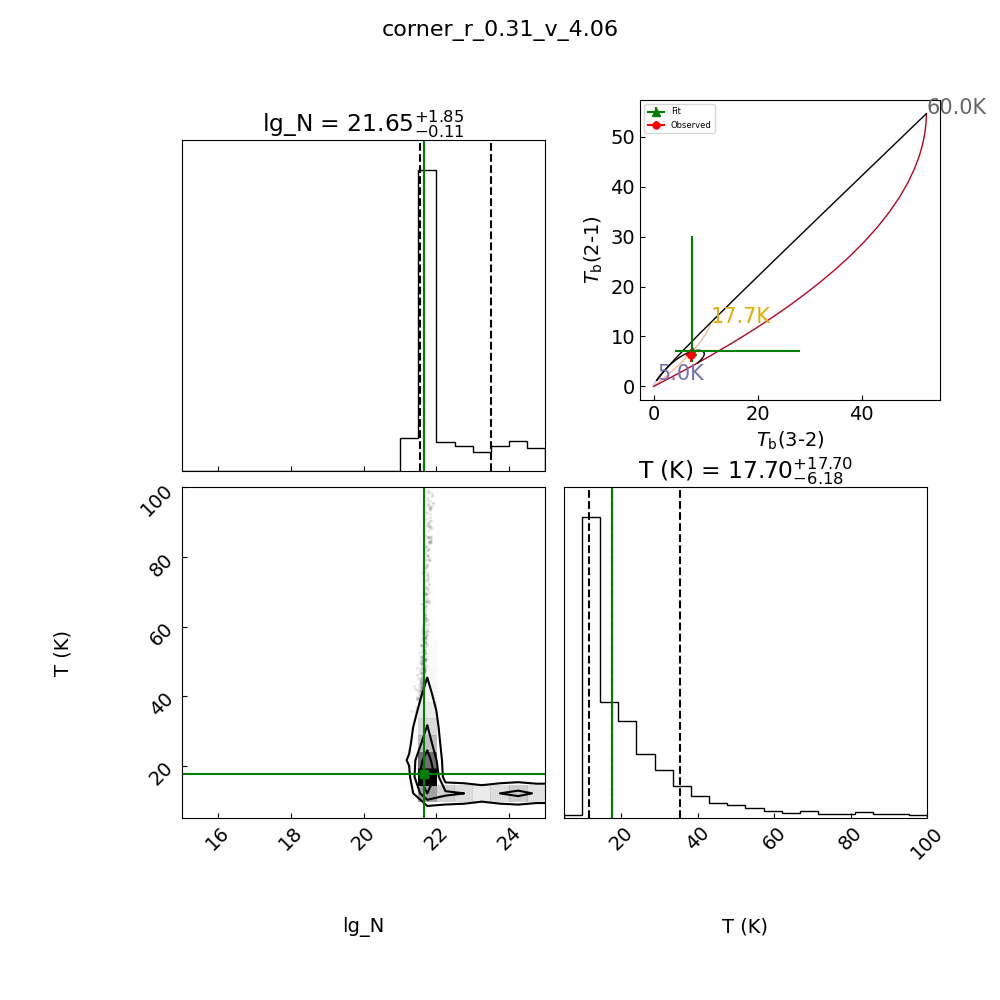

In [36]:
Texe_rs_empkep = []
Texe_upq_empkep = []
Texe_lq_empkep = []

Ncol_rs_empkep = []
Ncol_upq_empkep = []
Ncol_lq_empkep = []

plot_corner = True

np.random.seed(41)

N_conv_fraction = 1.e-7
lg_n_bounds = [15.,25.]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0],T_bounds[-1])

op_dir_label = "redshifted_points_empkep_test"

ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_sur_pt_rs"][15:16], Tb_df_b6["Tb_sur_pt_rs"][15:16], 
                          pv_b6.r_as_rs[15:16], pv_b6.v_rot_redshifted[15:16]):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, 
                                                    s1=np.sqrt((0.1*Tb7)**2 + 1.08**2), 
                                                    s2=np.sqrt((0.1*Tb6)**2 + 0.49**2), 
                                                estimator='mcmc', initial_params = [lg_n_init, T_init], 
                                                bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                initial_scatter = 0.1, args= None,
                                                nwalkers = 20, n_steps = 10000, burn_in = 2000, thin_by = 50, return_flat= True,
                                                intensity_model = lte_model, plot_chain = True, 
                                                r_v_info = [str(round(r,3)), str(round(v,2))], 
                                                chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),"chains",op_dir_label),
                                                show_chains = False)
                
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_empkep.append(T_qtls[0])
    Texe_rs_empkep.append(T_qtls[1])
    Texe_upq_empkep.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_empkep.append(Ncol_qtls[0])
    Ncol_rs_empkep.append(Ncol_qtls[1])
    Ncol_upq_empkep.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt,ax_lt = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7, tb6=Tb6, figure = fig1,
                                axes = ax)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        #plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [ ]:
# Calculate errorbars

T_err_empkep_rs = [np.array(Texe_rs_empkep)-np.array(Texe_lq_empkep),np.array(Texe_upq_empkep)-np.array(Texe_rs_empkep)] #[tl,tu] for tl,tu in zip(

N_err_empkep_rs = [np.array(Ncol_rs_empkep)-np.array(Ncol_lq_empkep), np.array(Ncol_upq_empkep)-np.array(Ncol_rs_empkep)]

In [ ]:
results_data = {"r_empkep_rs": pv_b6.r_as_rs,
        "Tb7_empkep_rs" : Tb_df_b7["Tb_on_point_rs"], "Tb6_empkep_rs" : Tb_df_b6["Tb_on_point_rs"],
        "Texe_rs_empkep" : Texe_rs_empkep, "Texe_err_rs_empkep" : np.array(T_err_empkep_rs).T.tolist(),
        "Ncol_rs_empkep" : Ncol_rs_empkep, "Ncol_err_rs_empkep" : np.array(N_err_empkep_rs).T.tolist()
        }

print(np.shape(T_err_empkep_rs))
print(len(pv_b6.r_as_rs), len(Tb_df_b7["Tb_on_point_rs"]), len(Tb_df_b6["Tb_on_point_rs"]), len( Ncol_rs_empkep),
      len(N_err_empkep_rs))
results_df = pd.DataFrame(data = results_data)

respath = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")
results_df.to_csv(path_or_buf= os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv"))

(2, 26)
26 26 26 26 2


#### Visualize results

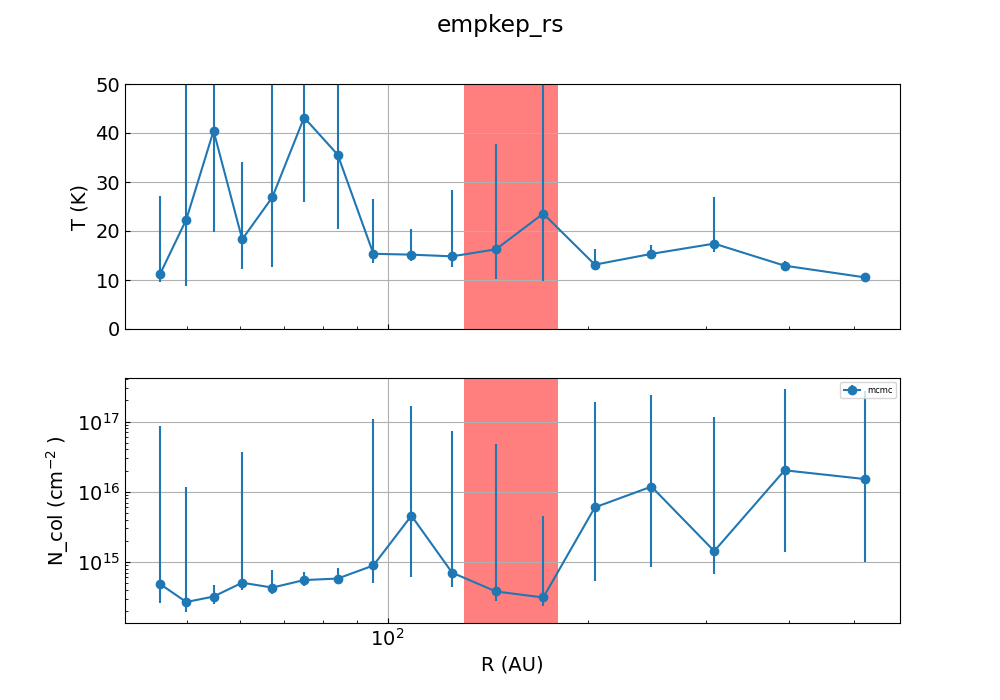

In [ ]:
vis_results_fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

acceptable_r_range = [0.3, 5.0]

ftd_r_as_rs, ftd_Texe_rs_empkep, ftd_Terr_rs_empkep = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Texe_rs_empkep, np.array(T_err_empkep_rs).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[0].errorbar(np.array(ftd_r_as_rs)*140., ftd_Texe_rs_empkep, yerr=np.array(ftd_Terr_rs_empkep).T, marker='o', label = 'mcmc')
axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
#axes[0].set_xlim(10, 800)
axes[0].set_ylim(0,50)
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[1].legend(prop={'size': 6})

ftd_r_as_rs, ftd_Ncol_rs_empkep, ftd_N_err_rs_empkep = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Ncol_rs_empkep, np.array(N_err_empkep_rs).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[1].errorbar(np.array(ftd_r_as_rs)*140., np.array(ftd_Ncol_rs_empkep)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_rs_empkep).T*N_conv_fraction, marker='o', label = 'mcmc')

axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})
axes[1].set_xlabel("R (AU)")

vis_results_fig.suptitle("empkep_rs")

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')

### Temperature estimation (fix r)

#### Read the Data

In [9]:
# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    is_Tb=True, v_sys=7.22) # V_sys - 7.22, 7.27
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_69_w1.fits',
                    is_Tb=True, v_sys=7.22)
pv_b6.read_pv(print_details = True)



Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
 rms = 1.08 K
Convert frequency to velocity
 rms = 6.92e-03 Jy beam$^-1$
 rms = 0.49 K


In [10]:
# define fix r points
# Get equidistance points

r_au_empkep_rs_fix_r = np.arange(start=42., step=42., stop=840.)
r_au_empkep_bs_fix_r = -r_au_empkep_rs_fix_r

v_100 = 3.2 #kmps # idpft-2.674 # JS- 3.2

v_rot_empkep_rs_fix_r =  emp_kep_r(r=r_au_empkep_rs_fix_r, r_b=100., v_100=v_100)
v_rot_empkep_bs_fix_r = - v_rot_empkep_rs_fix_r

plot_points = [r_au_empkep_rs_fix_r, v_rot_empkep_rs_fix_r, r_au_empkep_bs_fix_r, v_rot_empkep_bs_fix_r]

In [11]:
# Evaluate empirical keplerian curve function
r_rs_func = np.arange(start=1., step=0.5, stop=840.)   # Note that this is in AU
v_rs_func = emp_kep_r(r=r_rs_func, r_b=100., v_100=v_100)

r_bs_func = -r_rs_func
v_bs_func = -v_rs_func

In [12]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = plot_points, 
                                get_surrounding_pix = False, mode='vals',
                                num_pix = 3)
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = plot_points, 
                                    get_surrounding_pix = False, mode='vals',
                                    num_pix = 3)

#### Data Visualization

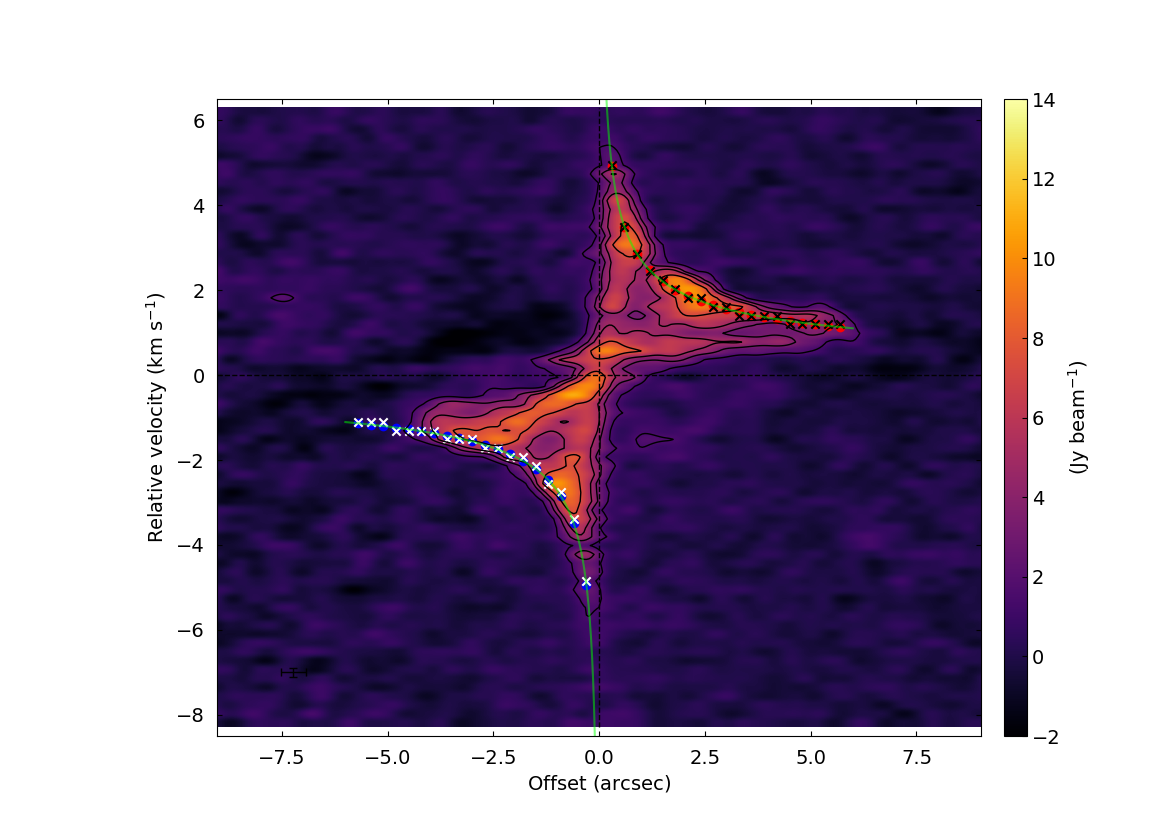

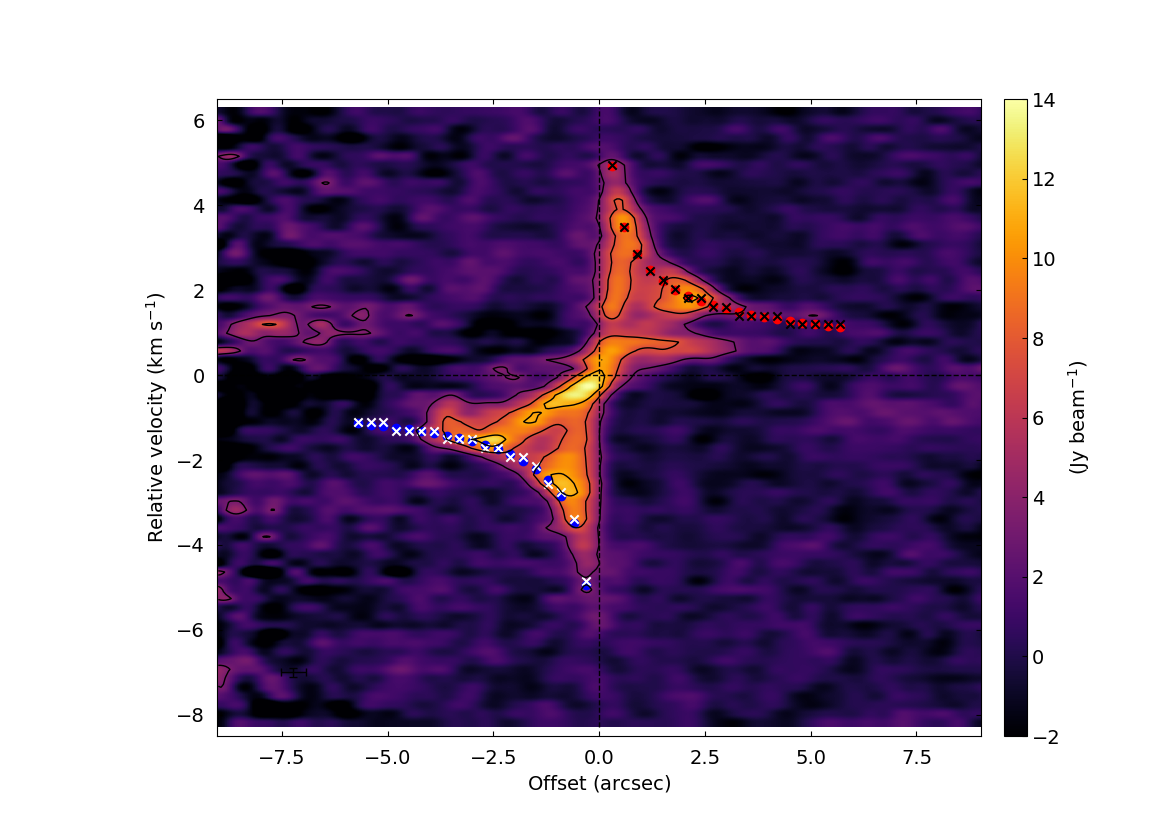

In [13]:

pv_dia6 = pv_b6.plot_pv(plot_curve=True)
pv_dia6[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_dia6[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)

pv_dia7 = pv_b7.plot_pv(plot_curve=True)

#### T estimation loop (fix r)

In [14]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for r = 3.000e-01 arcsec, v =  4.94 Kmps , Tb7 = 4.8, Tb6 = 2.0


100%|██████████| 10000/10000 [00:55<00:00, 180.86it/s]


dtauv_dT =  5.402640031844218e-07
dtauv_dT =  1.6863255996162323e-07
Tb7_dIv_dN = 2.33e-14, Tb6_dIv_dN = 1.51e-14
Tb7_dIv_dT = 0.09, Tb6_dIv_dT = 0.06
Ncols and lgNcols up 1.92e+21, lgNc = 2.13e+01
Ncols and lgNcols med 1.49e+21, lgNc = 2.12e+01
Ncols and lgNcols dwn 1.13e+21, lgNc = 2.11e+01
del T -> + 13.09, - 17.69
del N -> + 4.32e+20, - 3.58e+20
[[1.83551647 1.5727477 ]]
[[1.12454476 0.97764847]]


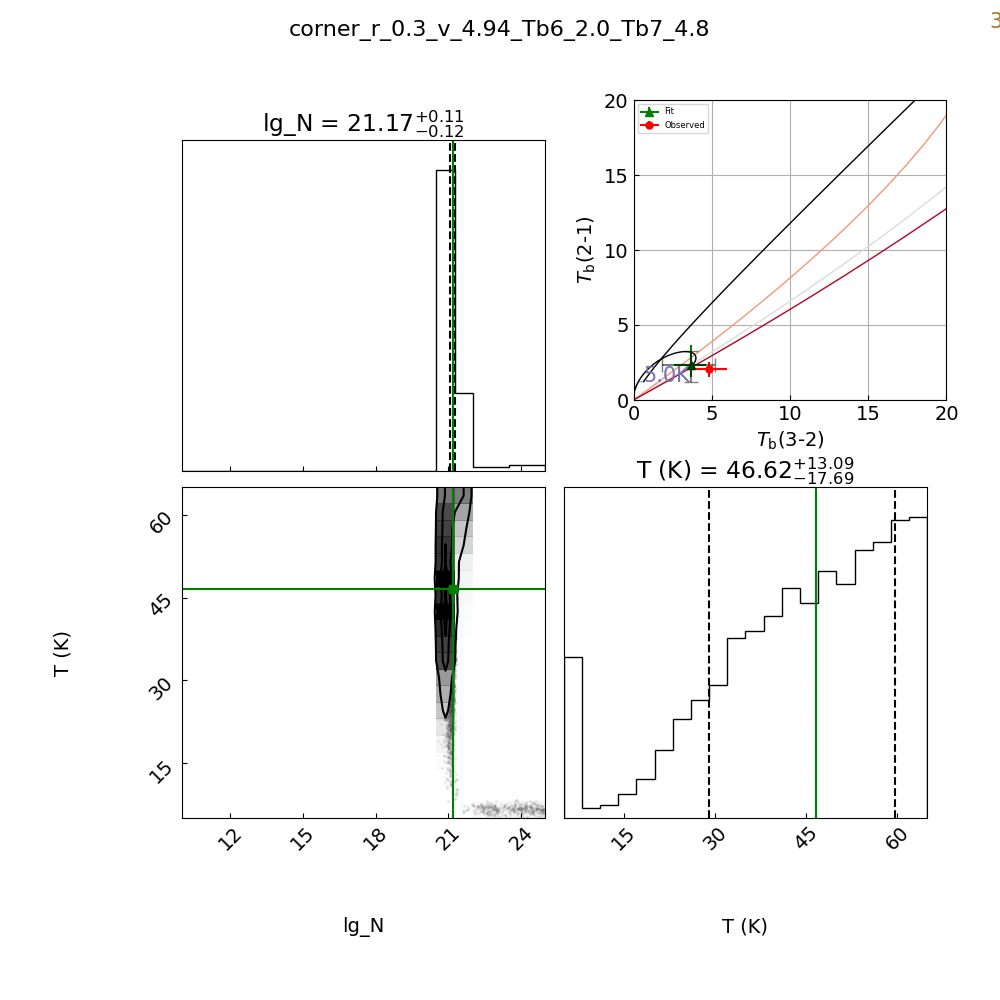

estimating for r = 6.000e-01 arcsec, v =  3.49 Kmps , Tb7 = 10.3, Tb6 = 7.6


100%|██████████| 10000/10000 [00:56<00:00, 176.18it/s]


dtauv_dT =  4.368751681329122e-06
dtauv_dT =  1.4515656345538758e-06
Tb7_dIv_dN = 1.76e-14, Tb6_dIv_dN = 1.36e-14
Tb7_dIv_dT = 0.34, Tb6_dIv_dT = 0.23
Ncols and lgNcols up 5.77e+21, lgNc = 2.18e+01
Ncols and lgNcols med 4.99e+21, lgNc = 2.17e+01
Ncols and lgNcols dwn 4.36e+21, lgNc = 2.16e+01
del T -> + 15.43, - 13.15
del N -> + 7.86e+20, - 6.26e+20
[[4.56431397 5.38001577]]
[[3.09819448 3.65649603]]


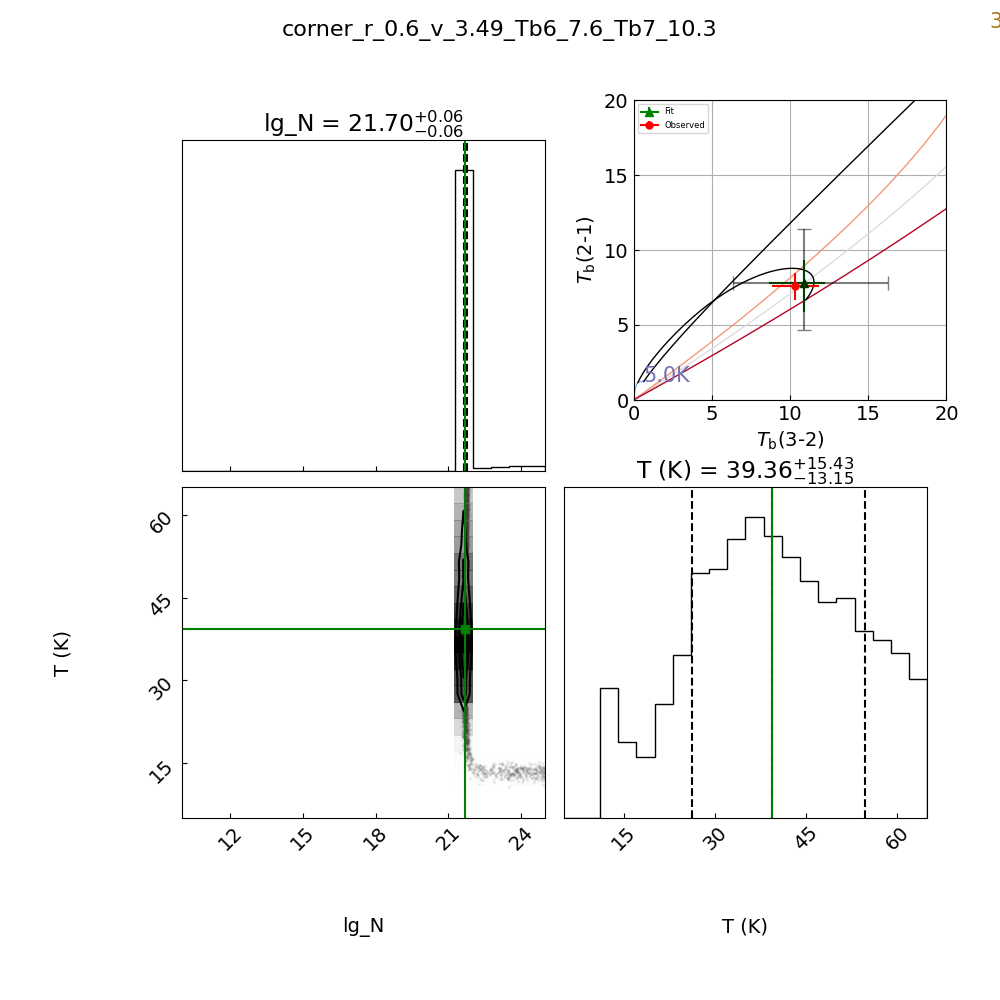

estimating for r = 9.000e-01 arcsec, v =  2.85 Kmps , Tb7 = 8.2, Tb6 = 7.4


100%|██████████| 10000/10000 [00:56<00:00, 175.48it/s]


dtauv_dT =  0.0001052490504778363
dtauv_dT =  5.0971828541069084e-05
Tb7_dIv_dN = 9.73e-15, Tb6_dIv_dN = 1.08e-14
Tb7_dIv_dT = 0.56, Tb6_dIv_dT = 0.52
Ncols and lgNcols up 4.68e+23, lgNc = 2.37e+01
Ncols and lgNcols med 5.03e+21, lgNc = 2.17e+01
Ncols and lgNcols dwn 3.98e+21, lgNc = 2.16e+01
del T -> + 16.23, - 7.50
del N -> + 4.63e+23, - 1.04e+21
[[  4.34224073 450.75819493]]
[[  4.0345441  498.72592171]]


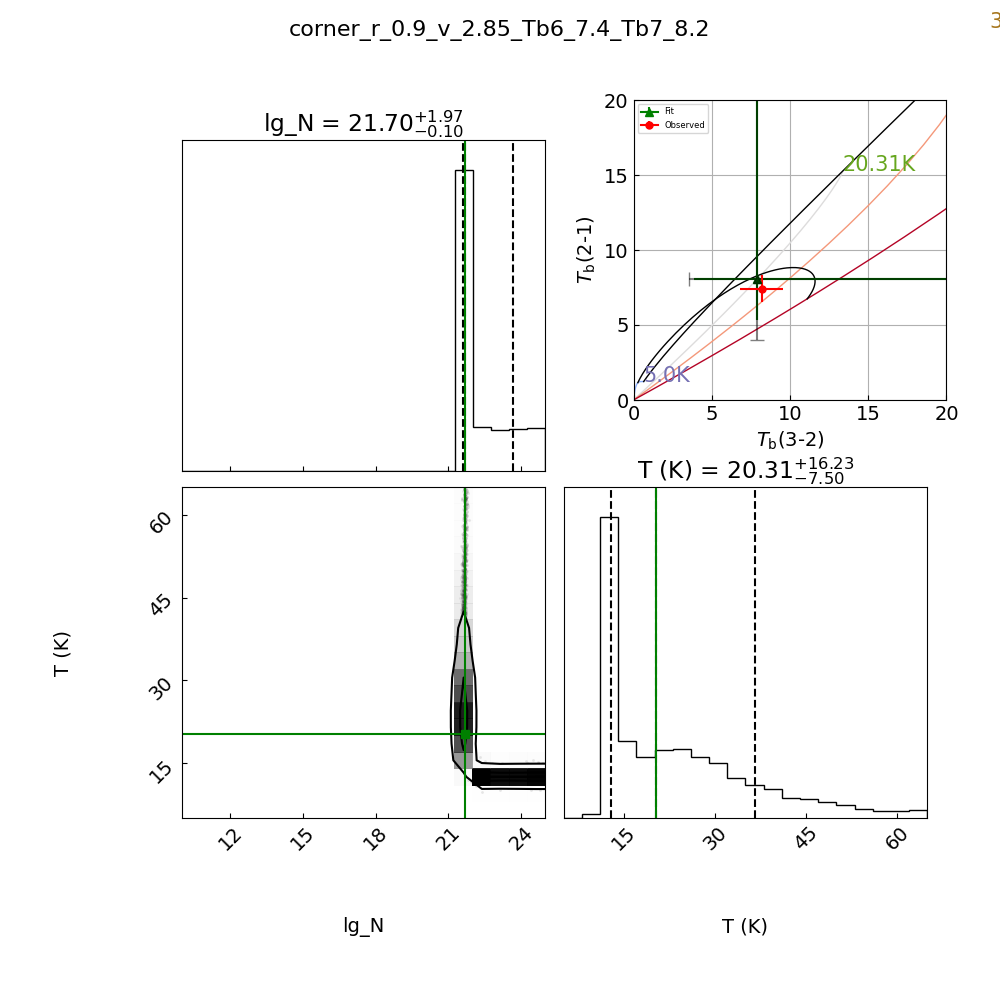

estimating for r = 1.200e+00 arcsec, v =  2.47 Kmps , Tb7 = 5.3, Tb6 = 4.5


100%|██████████| 10000/10000 [01:21<00:00, 122.42it/s]


dtauv_dT =  1.325142332331035e-05
dtauv_dT =  5.204013289591448e-06
Tb7_dIv_dN = 1.89e-14, Tb6_dIv_dN = 1.63e-14
Tb7_dIv_dT = 0.29, Tb6_dIv_dT = 0.22
Ncols and lgNcols up 5.25e+22, lgNc = 2.27e+01
Ncols and lgNcols med 2.67e+21, lgNc = 2.14e+01
Ncols and lgNcols dwn 2.19e+21, lgNc = 2.13e+01
del T -> + 20.26, - 17.93
del N -> + 4.98e+22, - 4.75e+20
[[ 5.21030222 94.6231301 ]]
[[ 3.95170532 81.57365267]]


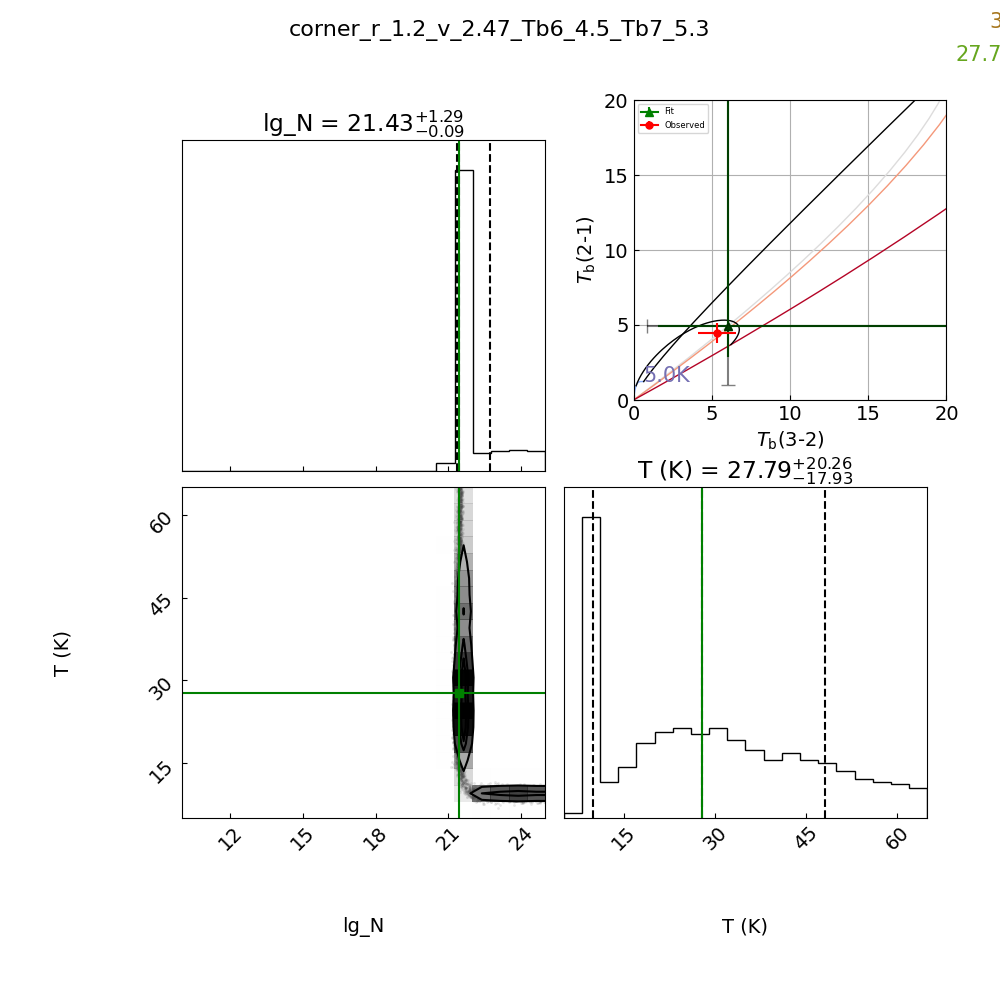

estimating for r = 1.500e+00 arcsec, v =  2.21 Kmps , Tb7 = 7.2, Tb6 = 8.2


100%|██████████| 10000/10000 [01:10<00:00, 142.24it/s]


dtauv_dT =  0.00790404452322619
dtauv_dT =  0.0055812226061332905
Tb7_dIv_dN = 3.58e-22, Tb6_dIv_dN = 5.01e-23
Tb7_dIv_dT = 0.90, Tb6_dIv_dT = 0.95
Ncols and lgNcols up 2.17e+24, lgNc = 2.43e+01
Ncols and lgNcols med 7.83e+22, lgNc = 2.29e+01
Ncols and lgNcols dwn 5.19e+21, lgNc = 2.17e+01
del T -> + 5.27, - 1.08
del N -> + 2.09e+24, - 7.31e+22
[[0.96338065 4.72241553]]
[[1.02380326 5.01860238]]


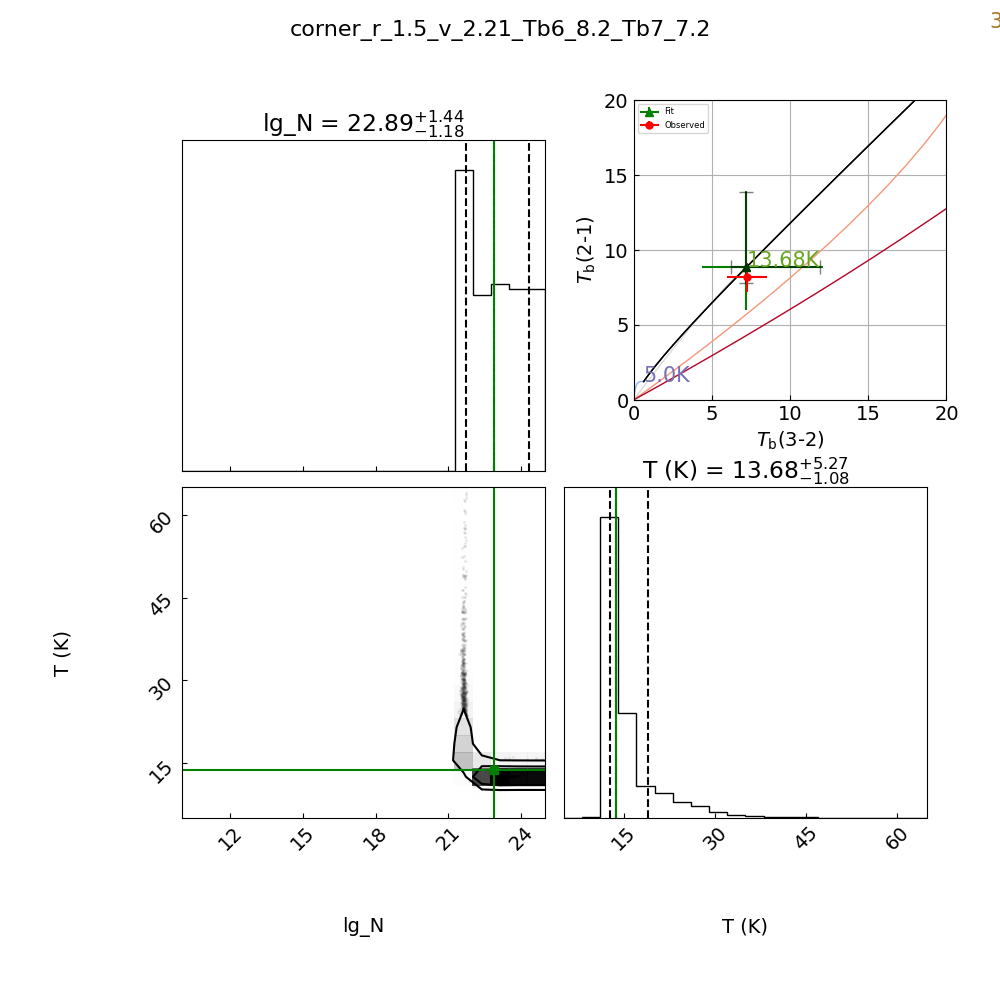

estimating for r = 1.800e+00 arcsec, v =  2.02 Kmps , Tb7 = 9.1, Tb6 = 9.8


100%|██████████| 10000/10000 [00:57<00:00, 173.35it/s]


dtauv_dT =  0.004682985311228994
dtauv_dT =  0.0028855701182795724
Tb7_dIv_dN = 2.63e-21, Tb6_dIv_dN = 2.50e-21
Tb7_dIv_dT = 0.92, Tb6_dIv_dT = 0.96
Ncols and lgNcols up 2.11e+24, lgNc = 2.43e+01
Ncols and lgNcols med 7.38e+22, lgNc = 2.29e+01
Ncols and lgNcols dwn 6.72e+21, lgNc = 2.18e+01
del T -> + 4.76, - 1.15
del N -> + 2.04e+24, - 6.71e+22
[[1.05330326 4.37253271]]
[[1.10453681 4.58521636]]


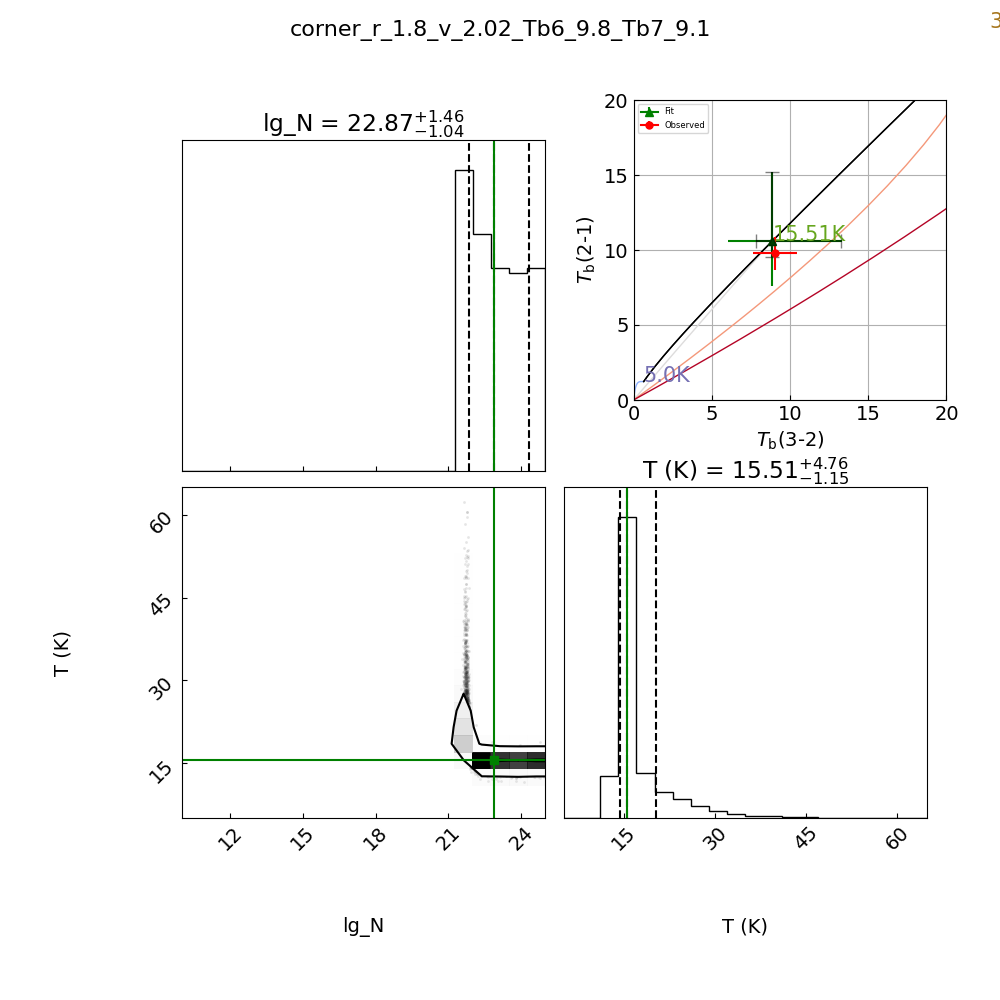

estimating for r = 2.100e+00 arcsec, v =  1.87 Kmps , Tb7 = 11.2, Tb6 = 9.8


100%|██████████| 10000/10000 [00:56<00:00, 177.12it/s]


dtauv_dT =  9.569765483027409e-05
dtauv_dT =  4.29426639845293e-05
Tb7_dIv_dN = 7.78e-15, Tb6_dIv_dN = 8.85e-15
Tb7_dIv_dT = 0.66, Tb6_dIv_dT = 0.59
Ncols and lgNcols up 5.69e+23, lgNc = 2.38e+01
Ncols and lgNcols med 7.22e+21, lgNc = 2.19e+01
Ncols and lgNcols dwn 5.72e+21, lgNc = 2.18e+01
del T -> + 15.64, - 6.97
del N -> + 5.61e+23, - 1.50e+21
[[  4.77152928 436.84481061]]
[[  4.34567554 497.05282412]]


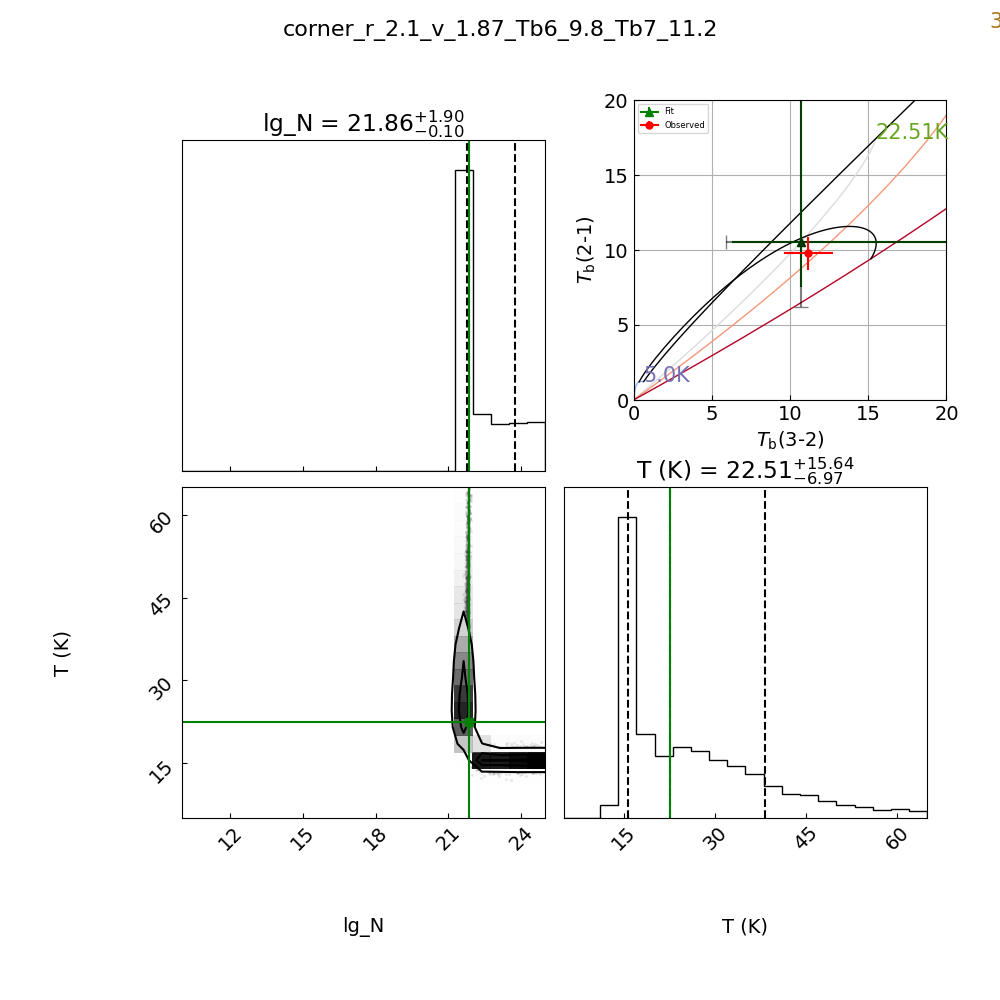

estimating for r = 2.400e+00 arcsec, v =  1.75 Kmps , Tb7 = 10.4, Tb6 = 9.8


100%|██████████| 10000/10000 [00:58<00:00, 171.94it/s]


dtauv_dT =  0.0004627402749604842
dtauv_dT =  0.0002561812468415008
Tb7_dIv_dN = 2.19e-15, Tb6_dIv_dN = 2.78e-15
Tb7_dIv_dT = 0.84, Tb6_dIv_dT = 0.85
Ncols and lgNcols up 1.05e+24, lgNc = 2.40e+01
Ncols and lgNcols med 1.13e+22, lgNc = 2.21e+01
Ncols and lgNcols dwn 5.71e+21, lgNc = 2.18e+01
del T -> + 13.98, - 2.25
del N -> + 1.04e+24, - 5.61e+21
[[  2.24785464 228.19634661]]
[[  2.47310957 290.01408587]]


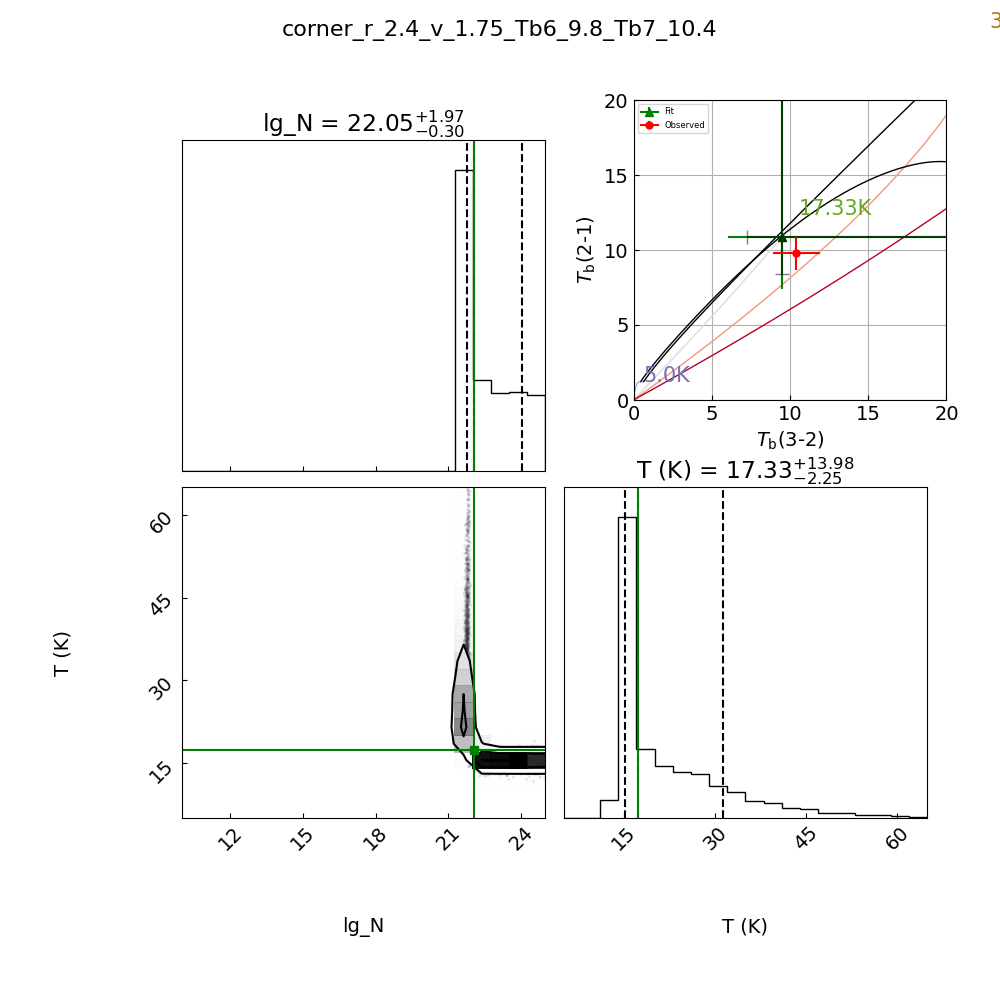

estimating for r = 2.700e+00 arcsec, v =  1.65 Kmps , Tb7 = 6.4, Tb6 = 8.8


100%|██████████| 10000/10000 [00:58<00:00, 169.76it/s]


dtauv_dT =  0.01361451902506384
dtauv_dT =  0.009703664594005
Tb7_dIv_dN = 2.27e-27, Tb6_dIv_dN = 5.31e-29
Tb7_dIv_dT = 0.89, Tb6_dIv_dT = 0.95
Ncols and lgNcols up 2.59e+24, lgNc = 2.44e+01
Ncols and lgNcols med 1.31e+23, lgNc = 2.31e+01
Ncols and lgNcols dwn 9.07e+21, lgNc = 2.20e+01
del T -> + 1.47, - 0.97
del N -> + 2.46e+24, - 1.22e+23
[[0.86794943 1.3127878 ]]
[[0.92328286 1.39648053]]


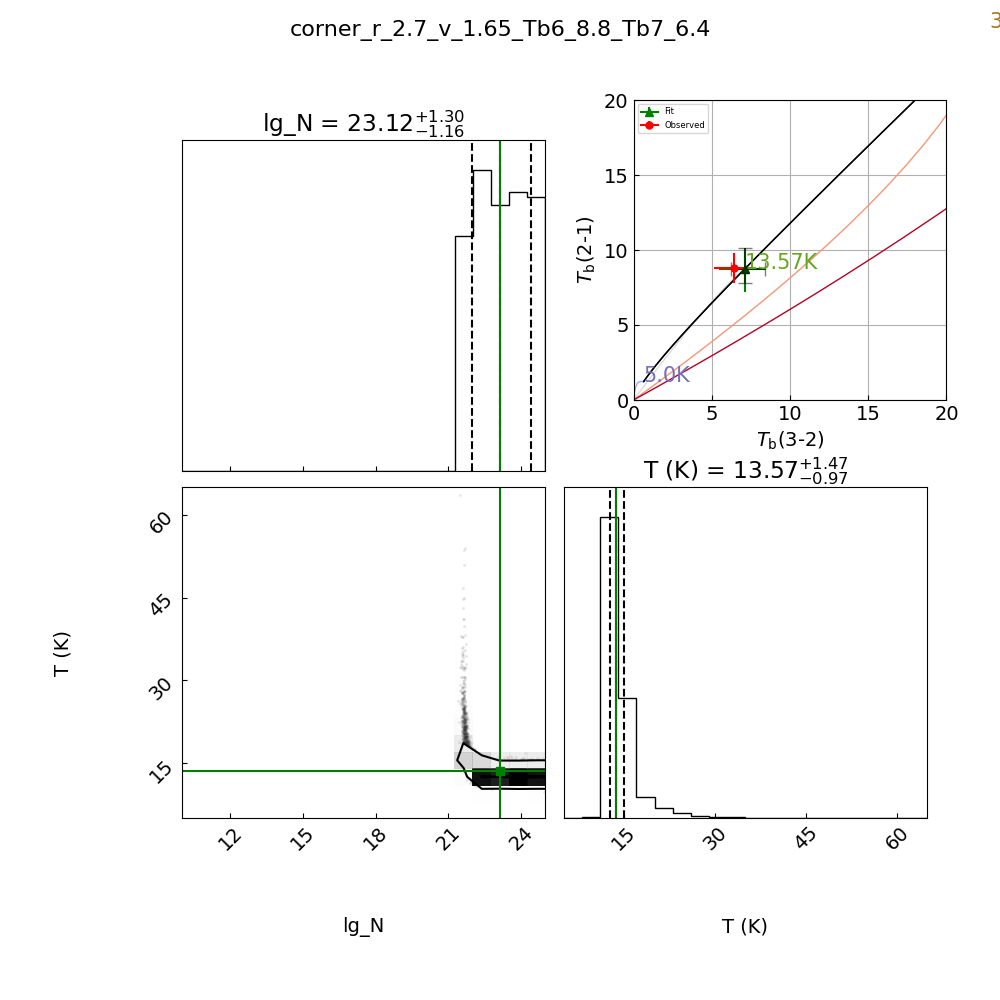

estimating for r = 3.000e+00 arcsec, v =  1.56 Kmps , Tb7 = 5.2, Tb6 = 8.2


100%|██████████| 10000/10000 [00:58<00:00, 169.55it/s]


dtauv_dT =  0.018773891604605953
dtauv_dT =  0.014597455411420632
Tb7_dIv_dN = 1.23e-28, Tb6_dIv_dN = 1.60e-31
Tb7_dIv_dT = 0.88, Tb6_dIv_dT = 0.94
Ncols and lgNcols up 2.61e+24, lgNc = 2.44e+01
Ncols and lgNcols med 1.41e+23, lgNc = 2.31e+01
Ncols and lgNcols dwn 9.39e+21, lgNc = 2.20e+01
del T -> + 1.23, - 0.88
del N -> + 2.46e+24, - 1.32e+23
[[0.77604551 1.07914432]]
[[0.83332018 1.15878866]]


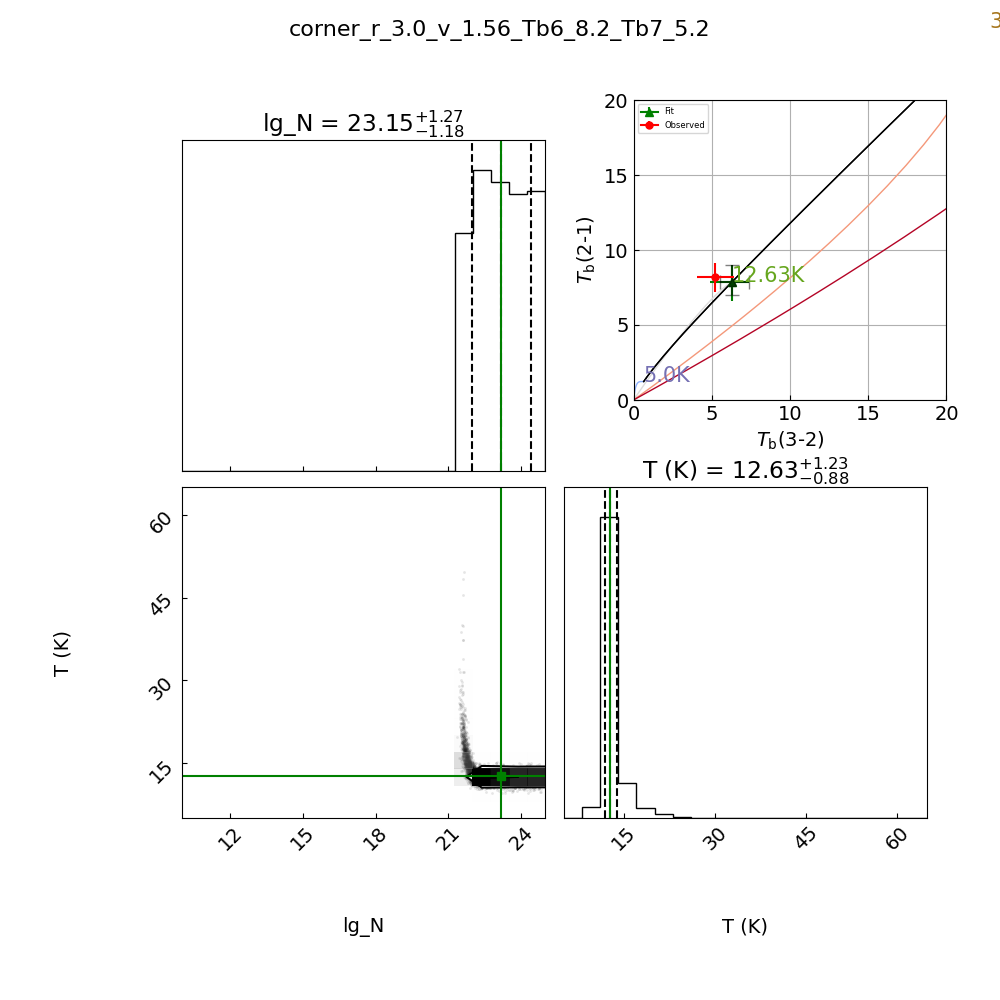

estimating for r = 3.300e+00 arcsec, v =  1.49 Kmps , Tb7 = 2.9, Tb6 = 6.5


100%|██████████| 10000/10000 [00:58<00:00, 169.59it/s]


dtauv_dT =  0.018577837615864647
dtauv_dT =  0.018114215020311082
Tb7_dIv_dN = 4.90e-23, Tb6_dIv_dN = 1.62e-26
Tb7_dIv_dT = 0.84, Tb6_dIv_dT = 0.92
Ncols and lgNcols up 2.27e+24, lgNc = 2.44e+01
Ncols and lgNcols med 8.32e+22, lgNc = 2.29e+01
Ncols and lgNcols dwn 5.74e+21, lgNc = 2.18e+01
del T -> + 1.37, - 0.87
del N -> + 2.19e+24, - 7.75e+22
[[0.72797657 1.1492835 ]]
[[0.80339909 1.26835582]]


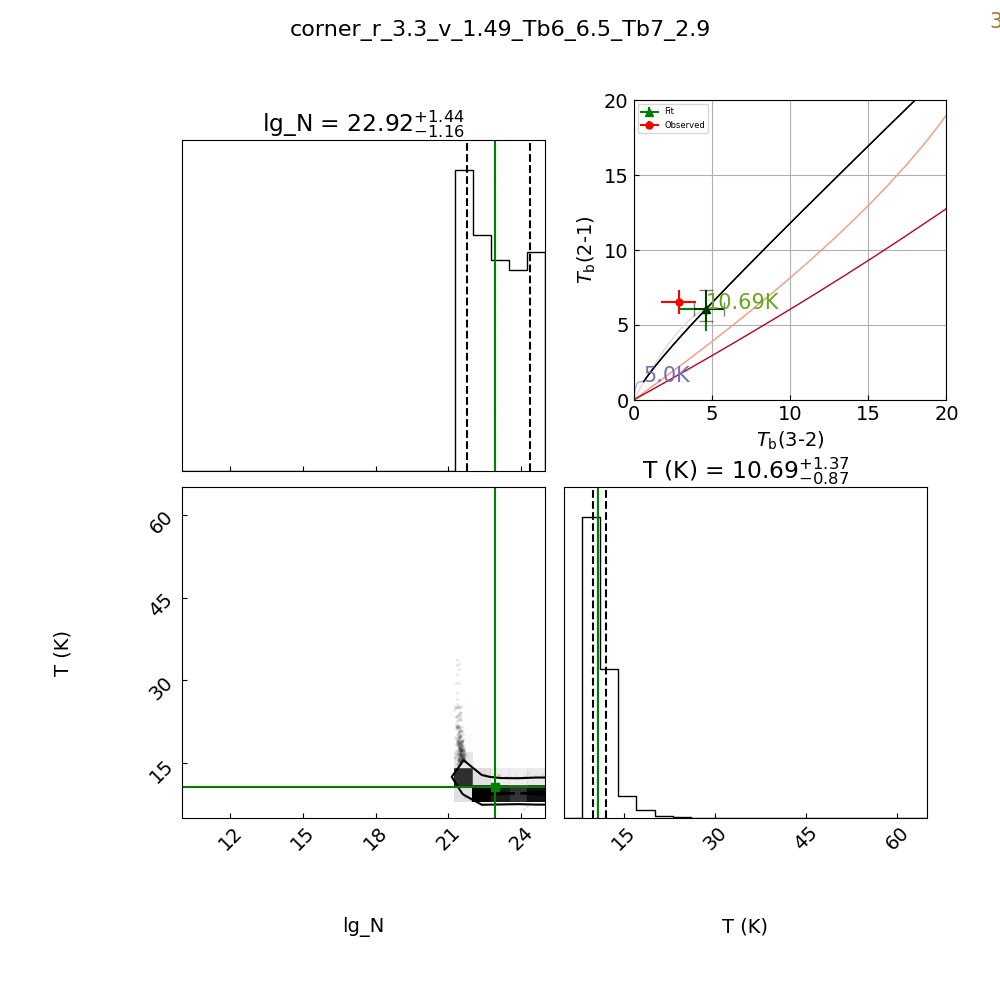

estimating for r = 3.600e+00 arcsec, v =  1.43 Kmps , Tb7 = 2.9, Tb6 = 6.6


100%|██████████| 10000/10000 [00:57<00:00, 173.45it/s]


dtauv_dT =  0.01929452174561728
dtauv_dT =  0.018788070062395447
Tb7_dIv_dN = 2.22e-23, Tb6_dIv_dN = 5.26e-27
Tb7_dIv_dT = 0.84, Tb6_dIv_dT = 0.92
Ncols and lgNcols up 2.21e+24, lgNc = 2.43e+01
Ncols and lgNcols med 8.66e+22, lgNc = 2.29e+01
Ncols and lgNcols dwn 5.87e+21, lgNc = 2.18e+01
del T -> + 1.30, - 0.86
del N -> + 2.13e+24, - 8.08e+22
[[0.71823682 1.08735533]]
[[0.79251353 1.19980456]]


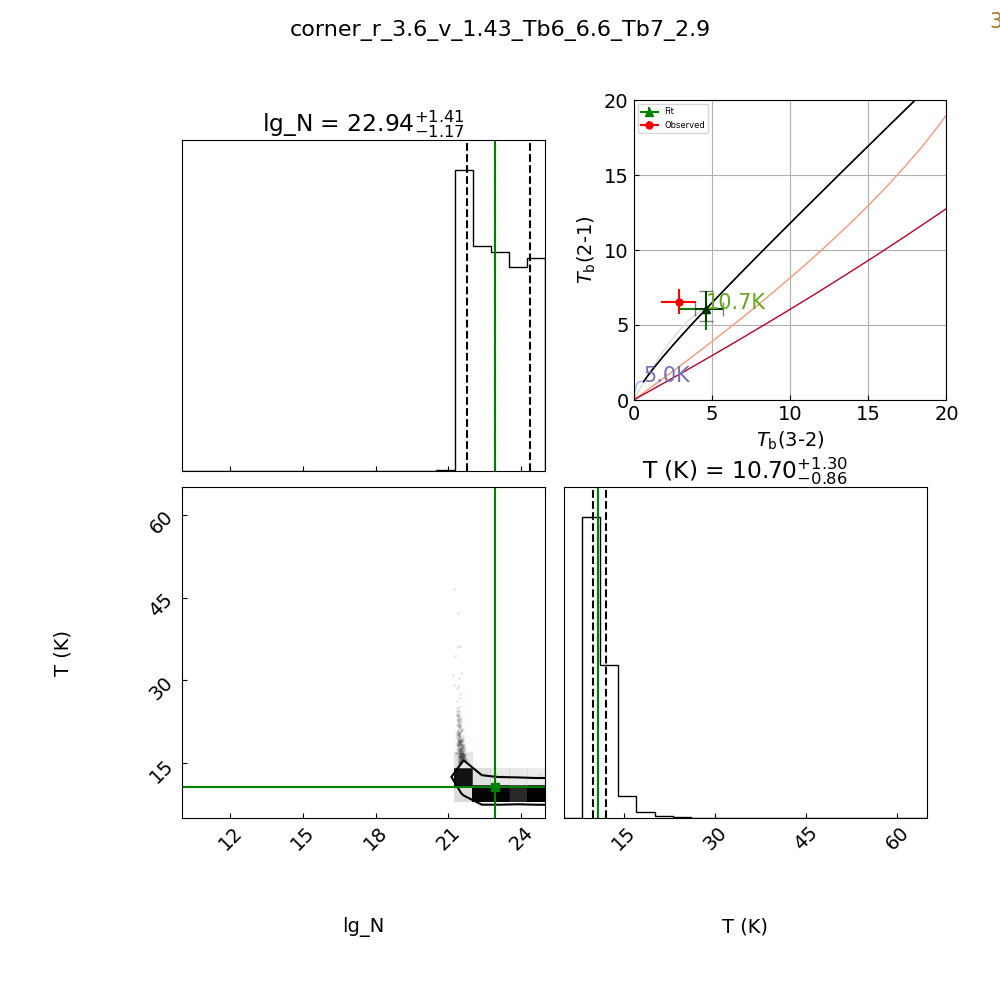

estimating for r = 3.900e+00 arcsec, v =  1.37 Kmps , Tb7 = 3.0, Tb6 = 6.3


100%|██████████| 10000/10000 [00:59<00:00, 168.75it/s]


dtauv_dT =  0.020366544314871532
dtauv_dT =  0.020128495645240704
Tb7_dIv_dN = 1.33e-23, Tb6_dIv_dN = 1.83e-27
Tb7_dIv_dT = 0.83, Tb6_dIv_dT = 0.92
Ncols and lgNcols up 2.16e+24, lgNc = 2.43e+01
Ncols and lgNcols med 8.89e+22, lgNc = 2.29e+01
Ncols and lgNcols dwn 5.45e+21, lgNc = 2.17e+01
del T -> + 1.46, - 0.84
del N -> + 2.07e+24, - 8.34e+22
[[0.6971902  1.22071829]]
[[0.77078231 1.34957155]]


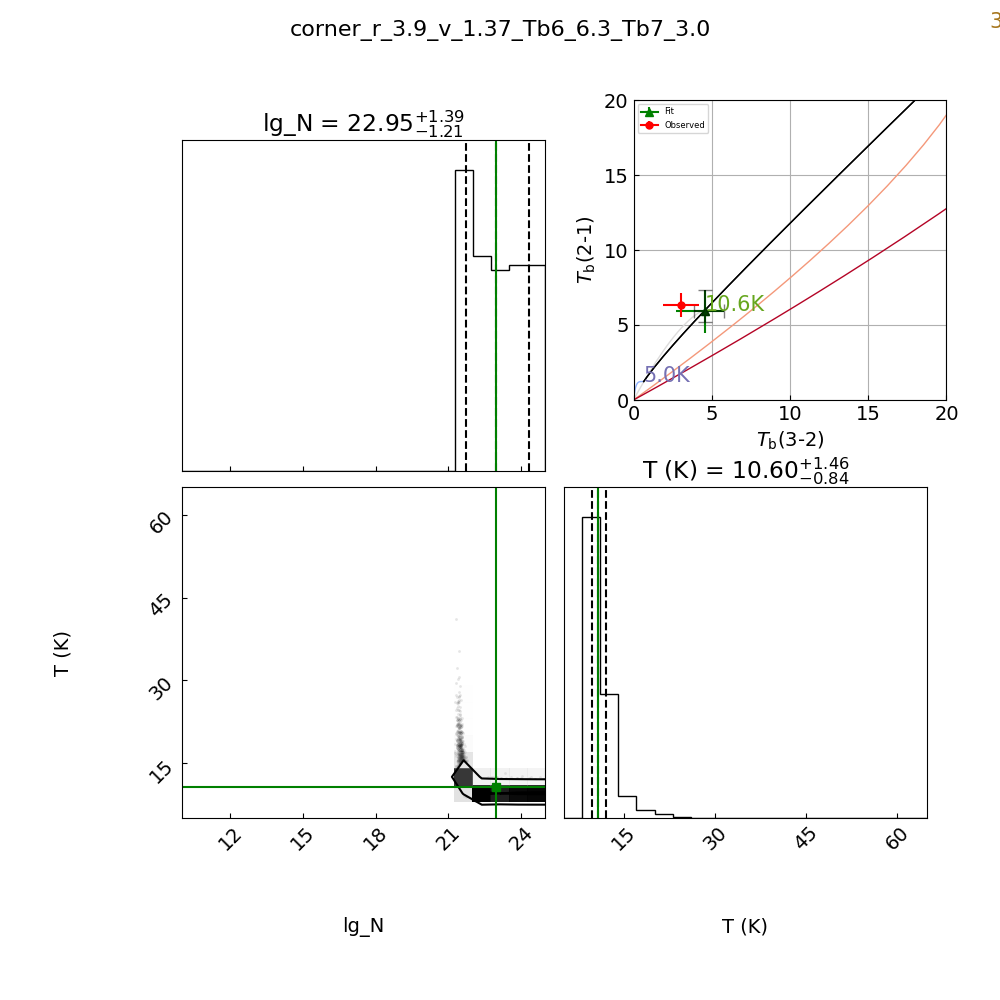

estimating for r = 4.200e+00 arcsec, v =  1.32 Kmps , Tb7 = 2.6, Tb6 = 6.0


100%|██████████| 10000/10000 [00:58<00:00, 170.81it/s]


dtauv_dT =  0.013878027618784495
dtauv_dT =  0.014424275587490225
Tb7_dIv_dN = 3.13e-20, Tb6_dIv_dN = 8.37e-23
Tb7_dIv_dT = 0.82, Tb6_dIv_dT = 0.92
Ncols and lgNcols up 1.92e+24, lgNc = 2.43e+01
Ncols and lgNcols med 5.52e+22, lgNc = 2.27e+01
Ncols and lgNcols dwn 4.70e+21, lgNc = 2.17e+01
del T -> + 1.75, - 0.87
del N -> + 1.86e+24, - 5.05e+22
[[0.71631701 1.44144756]]
[[0.79725728 1.60431092]]


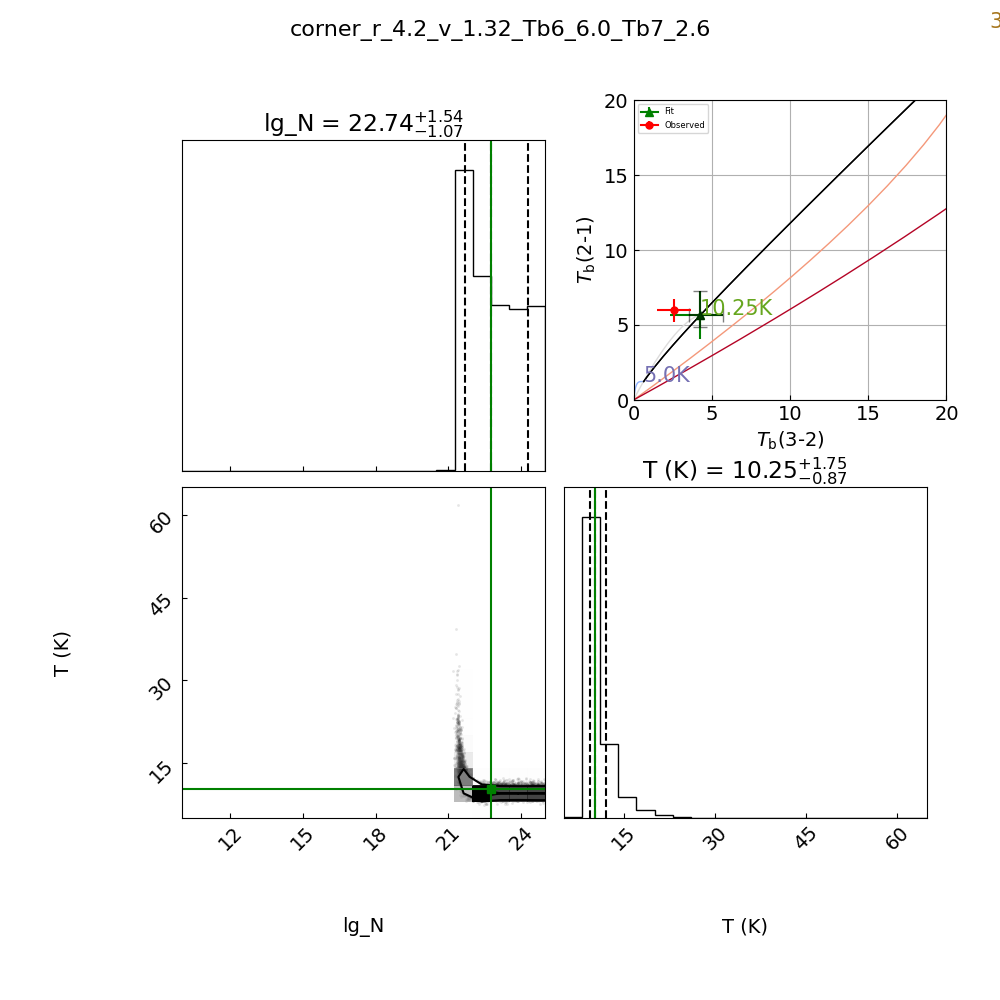

estimating for r = 4.500e+00 arcsec, v =  1.27 Kmps , Tb7 = 0.2, Tb6 = 3.7


100%|██████████| 10000/10000 [01:09<00:00, 143.69it/s]


dtauv_dT =  0.0055121230194421335
dtauv_dT =  0.008945406169602259
Tb7_dIv_dN = 4.12e-16, Tb6_dIv_dN = 7.58e-17
Tb7_dIv_dT = 0.67, Tb6_dIv_dT = 0.86
Ncols and lgNcols up 1.19e+24, lgNc = 2.41e+01
Ncols and lgNcols med 1.23e+22, lgNc = 2.21e+01
Ncols and lgNcols dwn 2.29e+21, lgNc = 2.14e+01
del T -> + 2.55, - 0.89
del N -> + 1.17e+24, - 1.00e+22
[[ 0.72169563 48.492022  ]]
[[0.76723638 9.17703036]]


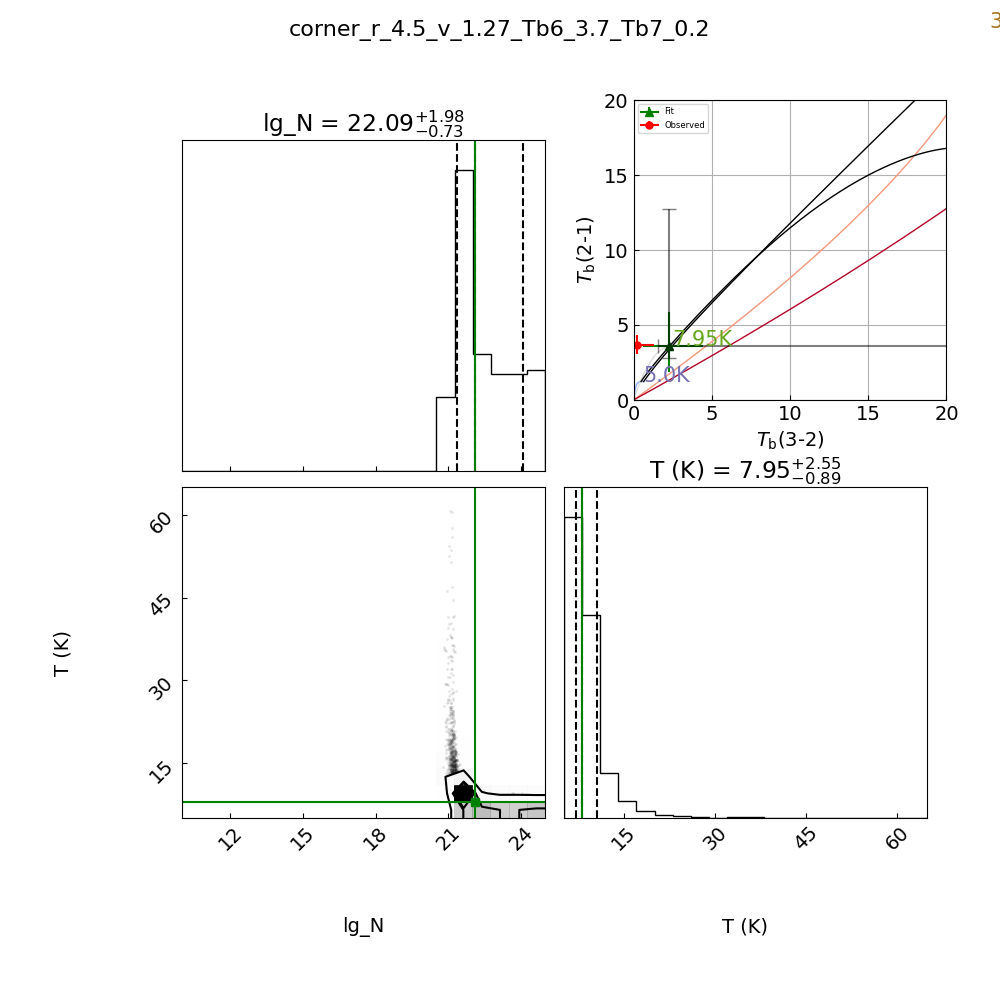

estimating for r = 4.800e+00 arcsec, v =  1.23 Kmps , Tb7 = 1.0, Tb6 = 4.5


100%|██████████| 10000/10000 [00:58<00:00, 171.36it/s]


dtauv_dT =  0.010225656928552946
dtauv_dT =  0.013921826468915316
Tb7_dIv_dN = 1.79e-17, Tb6_dIv_dN = 2.75e-19
Tb7_dIv_dT = 0.76, Tb6_dIv_dT = 0.89
Ncols and lgNcols up 1.55e+24, lgNc = 2.42e+01
Ncols and lgNcols med 2.74e+22, lgNc = 2.24e+01
Ncols and lgNcols dwn 3.15e+21, lgNc = 2.15e+01
del T -> + 2.02, - 0.86
del N -> + 1.53e+24, - 2.42e+22
[[0.6551317 3.138586 ]]
[[0.75866983 1.79393235]]


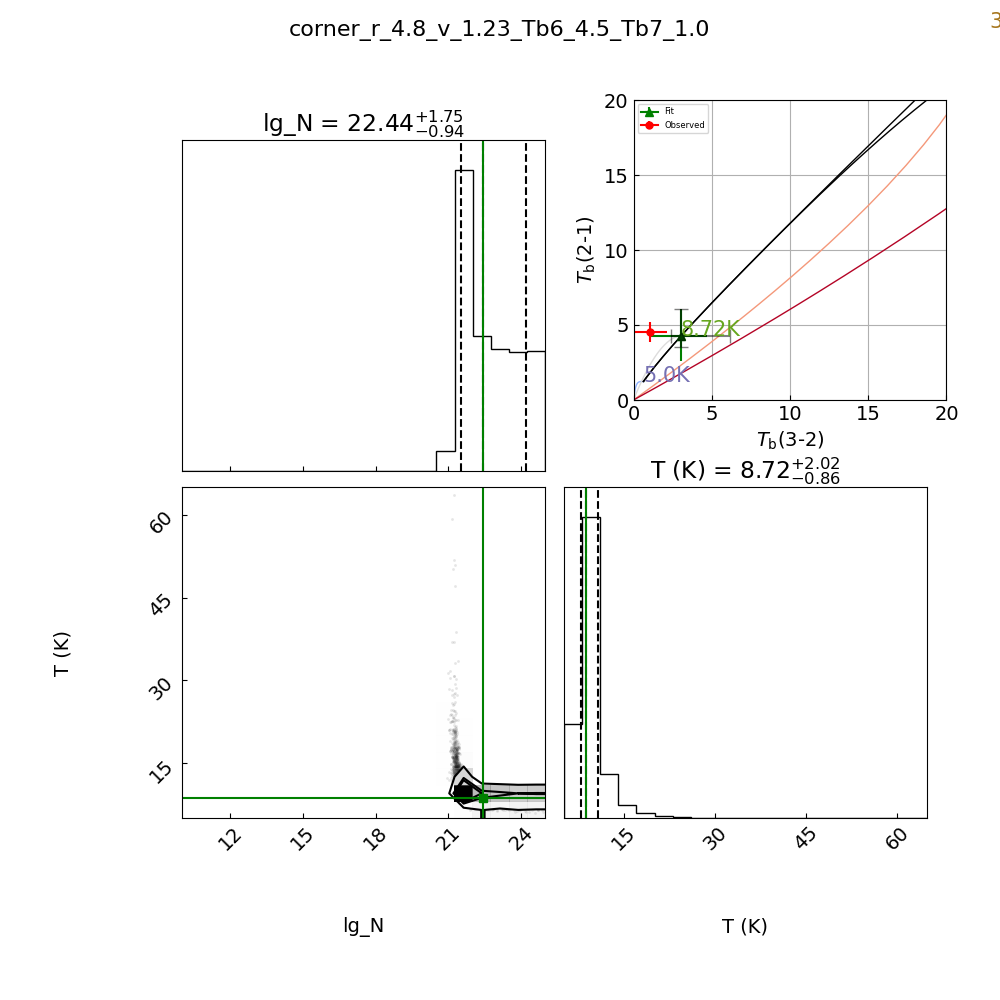

estimating for r = 5.100e+00 arcsec, v =  1.20 Kmps , Tb7 = 1.2, Tb6 = 4.3


100%|██████████| 10000/10000 [00:57<00:00, 172.47it/s]


dtauv_dT =  0.010434855332770126
dtauv_dT =  0.014533941938966378
Tb7_dIv_dN = 1.87e-17, Tb6_dIv_dN = 2.61e-19
Tb7_dIv_dT = 0.76, Tb6_dIv_dT = 0.88
Ncols and lgNcols up 1.50e+24, lgNc = 2.42e+01
Ncols and lgNcols med 2.72e+22, lgNc = 2.24e+01
Ncols and lgNcols dwn 2.99e+21, lgNc = 2.15e+01
del T -> + 2.28, - 0.84
del N -> + 1.48e+24, - 2.42e+22
[[0.64188768 3.25808096]]
[[0.74592312 2.01385177]]


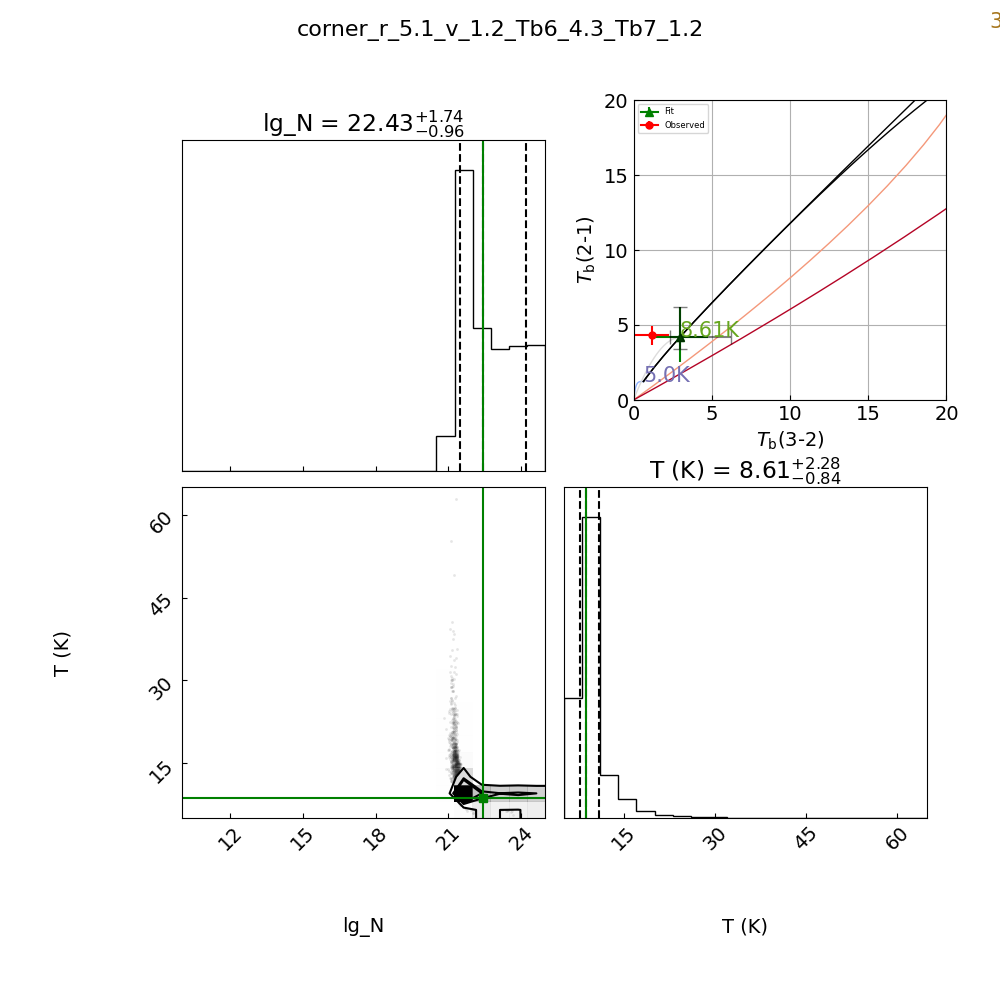

estimating for r = 5.400e+00 arcsec, v =  1.16 Kmps , Tb7 = 0.5, Tb6 = 3.7


100%|██████████| 10000/10000 [01:28<00:00, 112.71it/s]


dtauv_dT =  0.005612225970786936
dtauv_dT =  0.009024986897450665
Tb7_dIv_dN = 3.88e-16, Tb6_dIv_dN = 6.74e-17
Tb7_dIv_dT = 0.67, Tb6_dIv_dT = 0.86
Ncols and lgNcols up 1.25e+24, lgNc = 2.41e+01
Ncols and lgNcols med 1.26e+22, lgNc = 2.21e+01
Ncols and lgNcols dwn 2.14e+21, lgNc = 2.13e+01
del T -> + 3.02, - 0.91
del N -> + 1.24e+24, - 1.05e+22
[[ 0.73415664 48.11261727]]
[[0.78530784 8.74583221]]


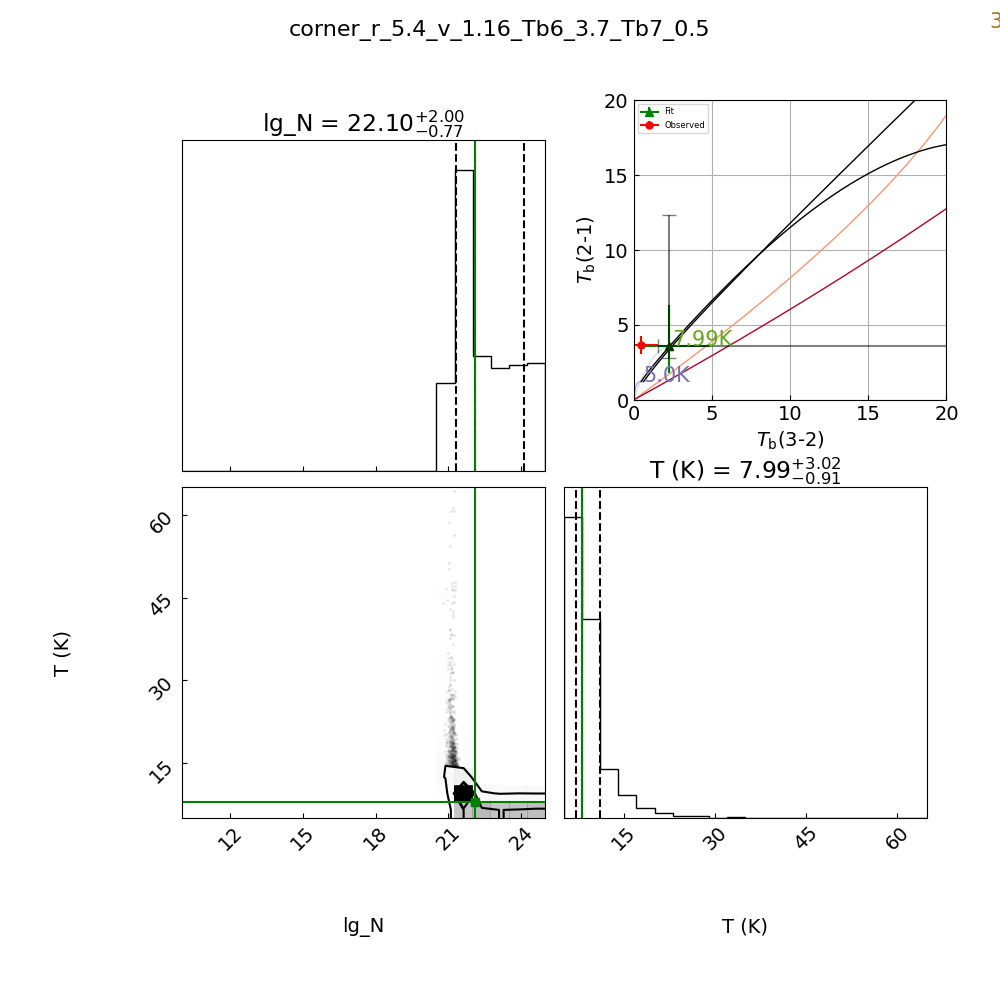

estimating for r = 5.700e+00 arcsec, v =  1.13 Kmps , Tb7 = 1.2, Tb6 = 3.3


100%|██████████| 10000/10000 [01:08<00:00, 146.58it/s]
d:\L1489_IRS_ssp\LTEAnalysis\Tb_estimator.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
C:\Users\mihirkumar\AppData\Local\Temp\ipykernel_7656\4181514131.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1 = plt.figure(figsize=(10,10))


dtauv_dT =  0.004530220410759934
dtauv_dT =  0.007391657483798922
Tb7_dIv_dN = 6.47e-16, Tb6_dIv_dN = 1.98e-16
Tb7_dIv_dT = 0.63, Tb6_dIv_dT = 0.85
Ncols and lgNcols up 1.02e+24, lgNc = 2.40e+01
Ncols and lgNcols med 1.01e+22, lgNc = 2.20e+01
Ncols and lgNcols dwn 1.52e+21, lgNc = 2.12e+01
del T -> + 7.18, - 1.00
del N -> + 1.01e+24, - 8.55e+21
[[ 0.83770129 65.1492255 ]]
[[ 0.86742102 20.77773521]]


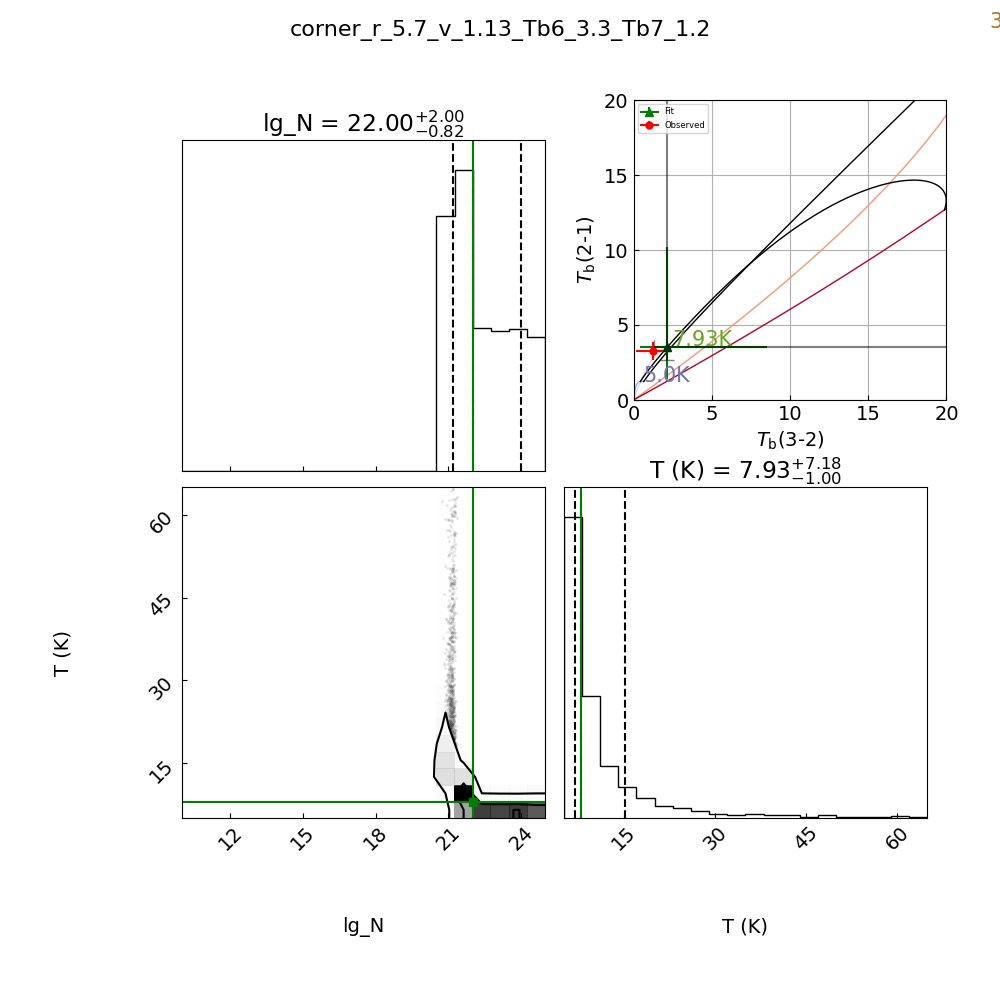

In [15]:
op_dir_label = "redshifted_points_empkep_fix_r_all_err"

Texe_rs_empkep_fix_r = []
Texe_upq_empkep_fix_r = []
Texe_lq_empkep_fix_r = []

Ncol_rs_empkep_fix_r = []
Ncol_upq_empkep_fix_r = []
Ncol_lq_empkep_fix_r = []

plot_corner = True

np.random.seed(41)

N_conv_fraction = 1.e-7
lg_n_bounds = [10.,25.]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0], T_bounds[-1])


ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_on_point_rs"], Tb_df_b6["Tb_on_point_rs"], 
                          pv_b6.r_as_rs, pv_b6.v_rot_redshifted):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, 
                                                    s1=np.sqrt( (0.1*Tb7)**2 + 1.08**2 ), #(0.1*Tb7)**2 + 1.08**2
                                                    s2=np.sqrt( (0.1*Tb6)**2 + 0.49**2),  # (0.1*Tb6)**2 + 0.49**2
                                     estimator='mcmc', initial_params = [lg_n_init, T_init], 
                                     bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                     initial_scatter = 0.1, args= None,
                                     nwalkers = 50, n_steps = 10000, burn_in = 2000, thin_by = 50, return_flat= True,
                                     intensity_model = lte_model, plot_chain = True, 
                                     r_v_info = [str(round(r,3)), str(round(v,2))], 
                                     chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),
                                                                    "chains",op_dir_label),
                                     show_chains = False)
    
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_empkep_fix_r.append(T_qtls[0])
    Texe_rs_empkep_fix_r.append(T_qtls[1])
    Texe_upq_empkep_fix_r.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_empkep_fix_r.append(Ncol_qtls[0])
    Ncol_rs_empkep_fix_r.append(Ncol_qtls[1])
    Ncol_upq_empkep_fix_r.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt,ax_lt = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7, tb6=Tb6, figure = fig1,
                                axes = ax)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)) + '_Tb6_' + str(round(Tb6,1))+ '_Tb7_' + str(round(Tb7,1)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [16]:
# Calculate errorbars

T_err_empkep_rs_fix_r = [np.array(Texe_rs_empkep_fix_r)-np.array(Texe_lq_empkep_fix_r),
                         np.array(Texe_upq_empkep_fix_r)-np.array(Texe_rs_empkep_fix_r)] 

N_err_empkep_rs_fix_r = [np.array(Ncol_rs_empkep_fix_r)-np.array(Ncol_lq_empkep_fix_r), 
                         np.array(Ncol_upq_empkep_fix_r)-np.array(Ncol_rs_empkep_fix_r)]

In [17]:
results_data_fix_r = {"r_empkep_rs_fix_r": pv_b6.r_as_rs,
        "Tb7_empkep_rs_fix_r" : Tb_df_b7["Tb_on_point_rs"], "Tb6_empkep_rs_fix_r" : Tb_df_b6["Tb_on_point_rs"],
        "Texe_rs_empkep_fix_r" : Texe_rs_empkep_fix_r, "Texe_err_rs_empkep_fix_r" : np.array(T_err_empkep_rs_fix_r).T.tolist(),
        "Ncol_rs_empkep_fix_r" : Ncol_rs_empkep_fix_r, "Ncol_err_rs_empkep_fix_r" : np.array(N_err_empkep_rs_fix_r).T.tolist()
        }
results_df_fix_r = pd.DataFrame(data = results_data_fix_r)

res_path = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")
print(res_path)
if not os.path.exists(res_path):

        df = pd.DataFrame(results_df_fix_r)
        df.to_csv(res_path, index=False)

existing_results = pd.read_csv(res_path)

updated_results = pd.concat([existing_results, results_df_fix_r], axis=1)

updated_results.to_csv(path_or_buf= res_path)

d:\L1489_IRS_ssp\LTEAnalysis\rs_empkep_fixr_results_all_err.csv


#### Visualize results

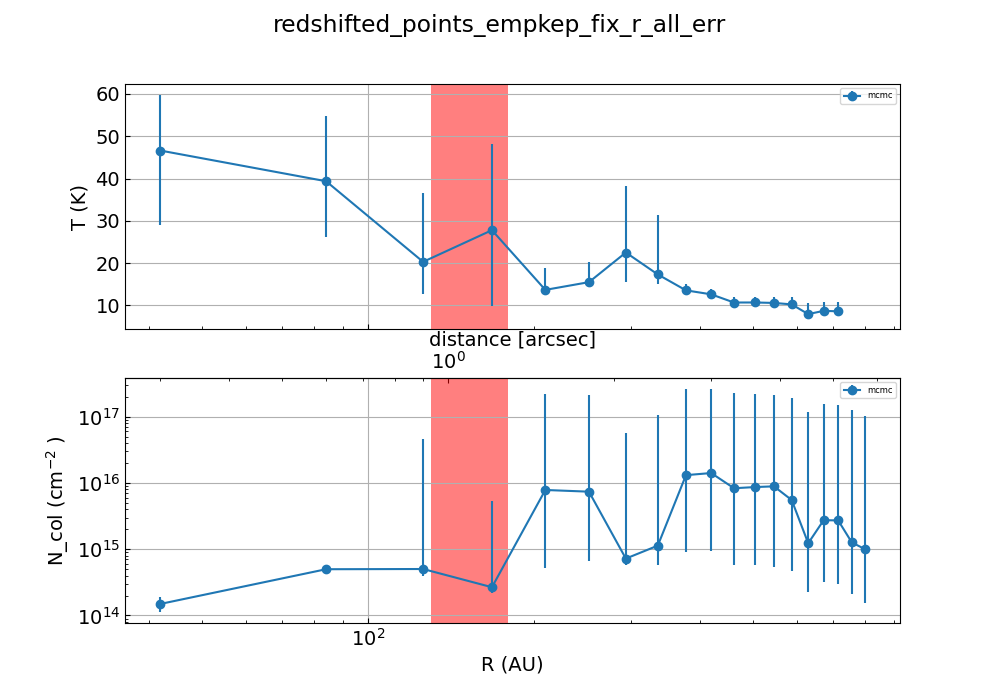

In [18]:
vis_results_fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

acceptable_r_range = [0.3, 15.0]

ftd_r_as_rs_fix_r, ftd_Texe_rs_empkep_fix_r, ftd_Terr_rs_empkep_fix_r = zip(*filter(lambda triple: acceptable_r_range[0] <= triple[0] 
                                                                                    <= 5.1, 
                                                                                    zip(pv_b6.r_as_rs, Texe_rs_empkep_fix_r, 
                                                                                        np.array(T_err_empkep_rs_fix_r).T.tolist())))

axes[0].errorbar(np.array(ftd_r_as_rs_fix_r)*140., ftd_Texe_rs_empkep_fix_r, 
                 yerr=np.array(ftd_Terr_rs_empkep_fix_r).T, marker='o', label = 'mcmc')
axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
#axes[0].set_xlim(10, 800)
#axes[0].set_ylim(0,50)
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[0].legend(prop={'size': 6})

ftd_r_as_rs_fix_r, ftd_Ncol_rs_empkep_fix_r, ftd_N_err_rs_empkep_fix_r = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Ncol_rs_empkep_fix_r, np.array(N_err_empkep_rs_fix_r).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[1].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.array(Ncol_rs_empkep_fix_r)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_rs_empkep_fix_r).T*N_conv_fraction, 
                 marker='o', label = 'mcmc')
axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})
axes[1].set_xlabel("R (AU)")


secax = axes[1].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))
secax.set_xlabel('distance [arcsec]')


vis_results_fig.suptitle(op_dir_label)

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)


if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')